# Tech Challenge 2: Timeseries Forecasting

**O Desafio:**


<img src="img/problema.png" width="800"/>

# Imports

In [57]:
import pandas as pd
import numpy as np

import seaborn as sns

import plotly.express as px
from plotly import graph_objects as go
from plotly.subplots import make_subplots

# data
import yfinance as yf
from bcb import sgs, currency
import ipeadatapy as idpy

# null values
import missingno as msno

from utils import *

# Data

## Ibovespa

In [58]:
# usar yfinance para pegar os dados do ibovespa de 2001-01-01 a hoje
# após estabilidade do plano real

yf.pdr_override() 

# ibovespa
ibovespa_df = yf.download('^BVSP', start='2001-01-01', end='2024-01-17', progress=False)

ibovespa_df

Open      High       Low     Close  Adj Close    Volume
Date                                                                   
2001-01-02   15242.0   15621.0   15174.0   15425.0    15425.0         0
2001-01-03   15425.0   16599.0   15251.0   16599.0    16599.0         0
2001-01-04   16597.0   16933.0   16587.0   16675.0    16675.0         0
2001-01-05   16679.0   16888.0   16380.0   16410.0    16410.0         0
2001-01-08   16398.0   16623.0   16226.0   16562.0    16562.0         0
...              ...       ...       ...       ...        ...       ...
2024-01-10  131447.0  131628.0  130438.0  130841.0   130841.0   8958400
2024-01-11  130841.0  131308.0  129898.0  130649.0   130649.0   9761700
2024-01-12  130652.0  131927.0  130410.0  130988.0   130988.0  10661900
2024-01-15  130988.0  131606.0  130253.0  131521.0   131521.0   5746600
2024-01-16  131515.0  131517.0  129147.0  129294.0   129294.0  11911300

[5703 rows x 6 columns]

In [59]:
ibovespa_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5703 entries, 2001-01-02 to 2024-01-16
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       5703 non-null   float64
 1   High       5703 non-null   float64
 2   Low        5703 non-null   float64
 3   Close      5703 non-null   float64
 4   Adj Close  5703 non-null   float64
 5   Volume     5703 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 311.9 KB


In [60]:
ibovespa_df.columns = ['open', 'high', 'low', 'close', 'adj_close', 'volume']

ibovespa_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5703 entries, 2001-01-02 to 2024-01-16
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   open       5703 non-null   float64
 1   high       5703 non-null   float64
 2   low        5703 non-null   float64
 3   close      5703 non-null   float64
 4   adj_close  5703 non-null   float64
 5   volume     5703 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 311.9 KB


0 - duplicate in the dataset


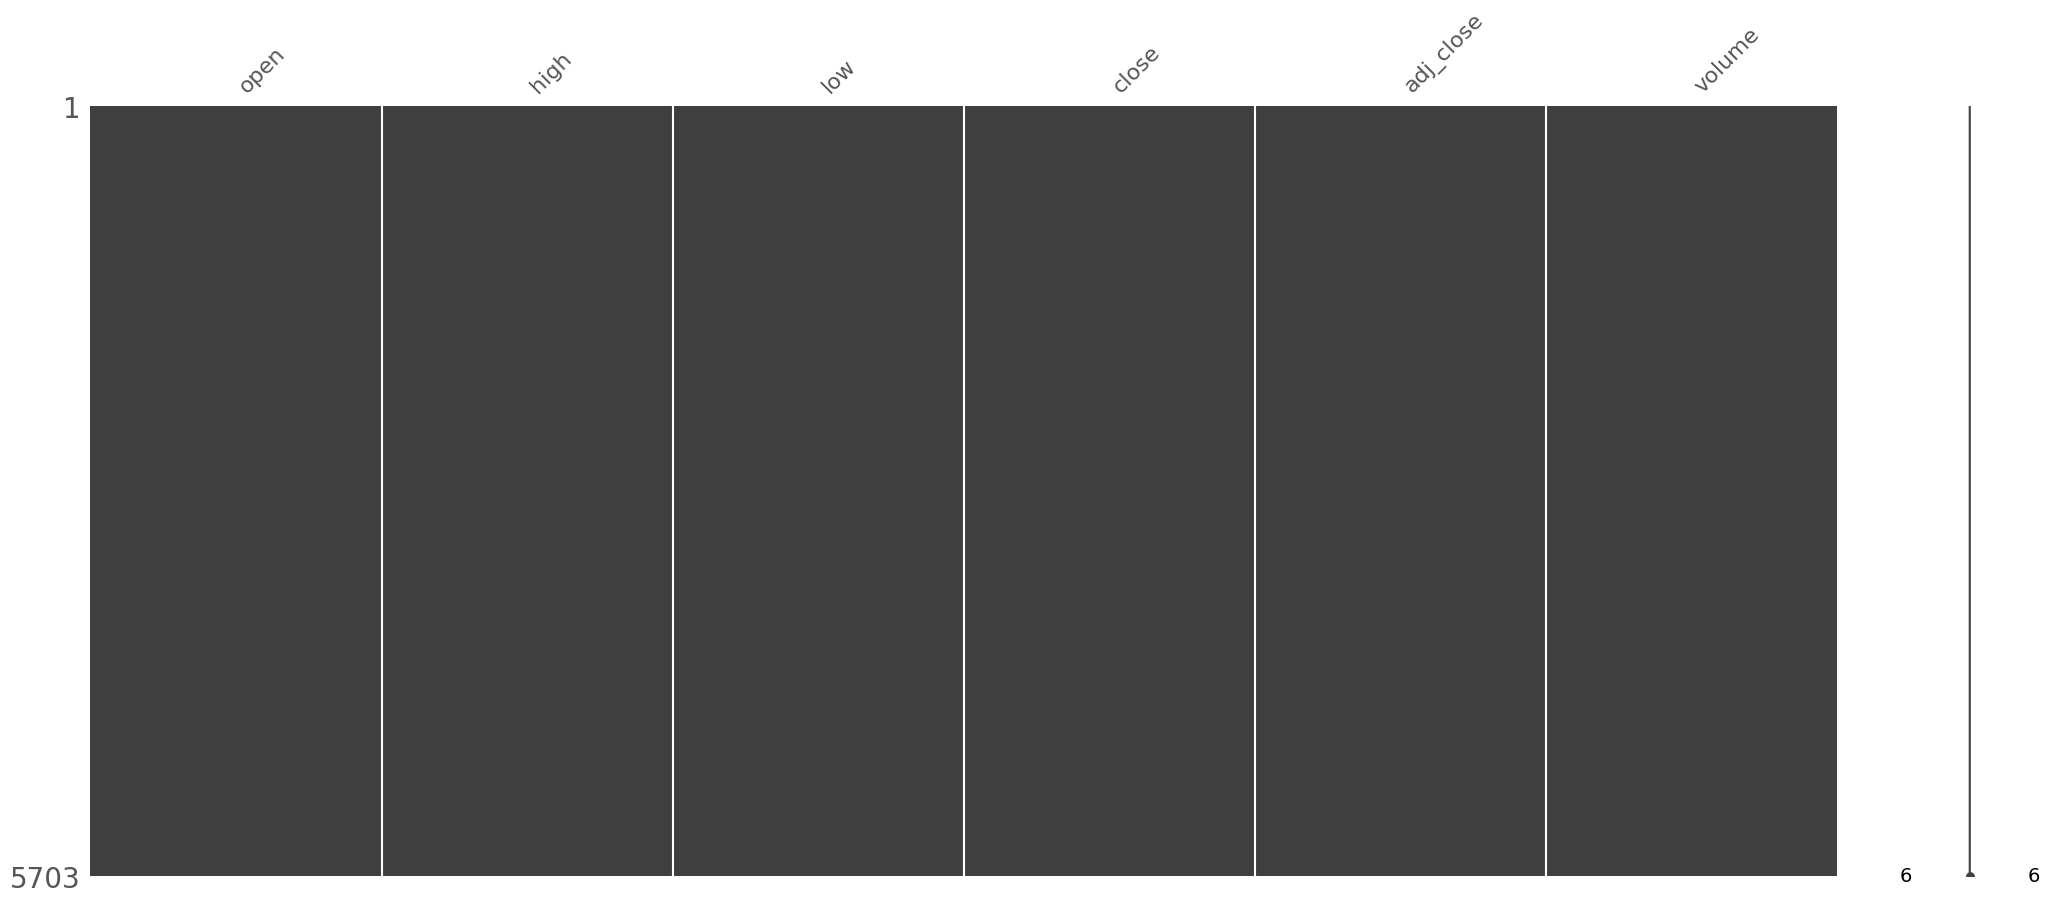

In [61]:
print(ibovespa_df.duplicated().sum(), '- duplicate in the dataset')

# check for missing values
msno.matrix(ibovespa_df); # o ; é um comando rápido em lugar de plt.show()

In [62]:
# apesar de não termos valores vazios, a coluna volume apresenta muitos valores zerados
print(f'Porcentagem de valores zerados na coluna volume: {round((ibovespa_df.volume == 0).sum() / len(ibovespa_df) * 100, 2)}%')

# ao substituir ou interpolar nessa coluna,
# já que está diretamente ligada ao preço das ações (target),
# podemos acabar com um viés no modelo, usando dados futuros para prever o passado (data leakage)

Porcentagem de valores zerados na coluna volume: 25.74%


O Ibovespa (Índice da Bolsa de Valores de São Paulo), fundado em 1968, reflete o desempenho médio das cotações dos ativos mais negociados e representativos do mercado de ações brasileiro. O indicador é composto por uma carteira teórica periodicamente ajustada, na tentativa de incorporar os ativos de maior relevância no cenário financeiro.

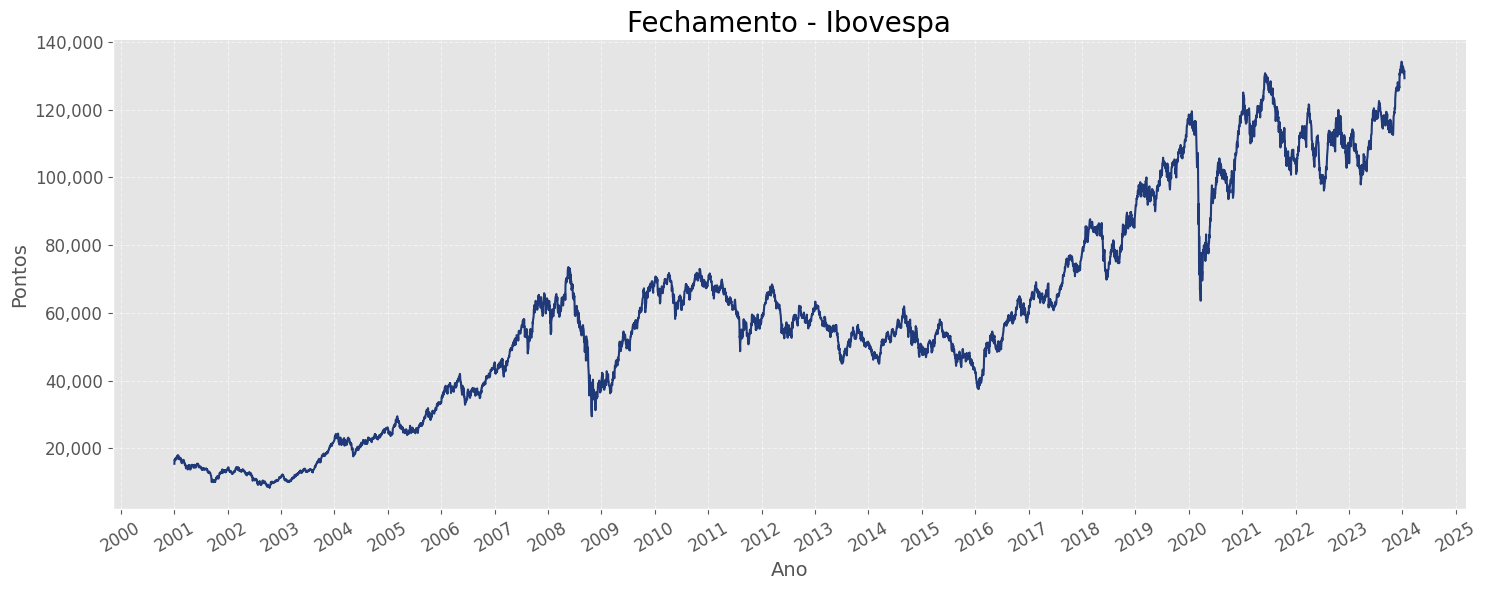

In [63]:
# Ibovespa a partir dos anos 2001
plot_series(ibovespa_df, 'close', title='Fechamento - Ibovespa',
            ylabel='Pontos', xlabel='Ano')

In [64]:
# datas importantes
# pré-sal foi descoberto em 2006 e marcou o início de um ciclo de crescimento econômico
pre_sal = pd.date_range(start='2006-01-01', end='2007-12-31')

# crise de 2008 nos EUA
crise_2008 = pd.date_range(start='2008-09-15', end='2009-03-09')

# Dilma fazia parte do conselho da adm. Petrobras,
# 2014 - Lava Jato
# inclui pedido de impeachment até a saída de Dilma Rousseff
impeachment_crise_petrobras = pd.date_range(start='2014-03-01', end='2016-05-31')

# pandemia do coronavírus em 2020
pandemia_2020 = pd.date_range(start='2020-03-11', end='2021-08-16')

# anos de eleição presidencial
anos_eleicoes = np.arange(2002, 2026, 4)

In [65]:
fig = go.Figure()

# fechamento do ibovespa
fig.add_trace(go.Scatter(x=ibovespa_df.index, 
                        y=ibovespa_df.close, 
                        name='Fechamento', 
                        hovertemplate='Fechamento: %{y:,.0f}',
                        line=dict(color='#1f3979', width=2)))
# fonte tamanho 16 no título
fig.update_layout(title=dict(text='Fechamento - Ibovespa', font=dict(size=18)),
                xaxis_title='Ano',
                yaxis_title='Pontos',
                legend_title='Legenda',
                legend=dict(x=0.02, y=0.98),
                hovermode='x unified',
                template='plotly_white')
                        
# linhas verticais para anos de eleição
for ano in anos_eleicoes:
    fig.add_vline(x=ibovespa_df.index[ibovespa_df.index.year == ano][0], 
                    line_width=1, line_dash='dash', line_color='lightgrey')
# áreas para datas importantes
fig.add_vrect(x0=pre_sal[0], x1=pre_sal[-1], line_width=0, fillcolor='#7DF2C9', opacity=0.2)
fig.add_vrect(x0=crise_2008[0], x1=crise_2008[-1], line_width=0, fillcolor='#D261B0', opacity=0.2)
fig.add_vrect(x0=impeachment_crise_petrobras[0], x1=impeachment_crise_petrobras[-1], line_width=0, fillcolor='#D1B25B', opacity=0.2)
fig.add_vrect(x0=pandemia_2020[0], x1=pandemia_2020[-1], line_width=0, fillcolor='#A32F24', opacity=0.2)

# anotar datas importantes fora do plot
fig.add_annotation(x=pre_sal[0], y=ibovespa_df.close.max(), 
                    text='Pré-sal',
                    # cor do texto
                    font=dict(color='#203D33'),
                    # seta
                    showarrow=False,
                    # posição do texto
                    xanchor='left',
                    yanchor='bottom')
# crise de 2008
fig.add_annotation(x=crise_2008[0], y=ibovespa_df.close.max(), 
                    text='Crise EUA',
                    font=dict(color='#3F1D35'),
                    showarrow=False,
                    xanchor='left',
                    yanchor='bottom')
# impeachment de Dilma
fig.add_annotation(x=impeachment_crise_petrobras[0], y=ibovespa_df.close.max(), 
                    text='Crise Petrobras<br>Impeachment Dilma',
                    font=dict(color='#3F351C'),
                    showarrow=False,
                    xanchor='left',
                    yanchor='bottom'
                    )
# pandemia de 2020
fig.add_annotation(x=pandemia_2020[0], y=ibovespa_df.close.max(), 
                    text='Pandemia COVID-19',
                    font=dict(color='#510402'),
                    showarrow=False,
                    xanchor='left',
                    yanchor='bottom')
# seta para linha tracejada de 2002
fig.add_annotation(x=ibovespa_df.index[ibovespa_df.index.year == 2002][0], 
                    y=ibovespa_df.close.max(), 
                    text='Eleições Presidenciais',
                    font=dict(color='grey'),
                    showarrow=True,
                    xanchor='left',
                    yanchor='bottom',
                    ax=50, ay=-50,
                    arrowhead=1,
                    arrowsize=1,
                    arrowwidth=2,
                    arrowcolor='grey')
fig.show()
# exportar para html
#fig.write_html('output/ibovespa.html')

## Selic

Fonte: https://analisemacro.com.br/economia/indicadores/coletando-dados-da-selic-com-o-python/

"Em seguida, devemos buscar o código da série da Taxa Meta Selic no site do SGS, que é disponibilizado pelo código 432. Com o código em mãos, utilizamos a função sgs.get(), com argumentos 'selic' (para o nome da coluna no data frame importado) e '432', referente ao código para a importação. Veja que configuramos um período de início, a partir de 2010."

In [66]:
selic_df = sgs.get(('selic', 432), start = '2001-01-01')

selic_df.head()

selic
Date             
2001-01-01  15.75
2001-01-02  15.75
2001-01-03  15.75
2001-01-04  15.75
2001-01-05  15.75

In [67]:
selic_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8427 entries, 2001-01-01 to 2024-01-27
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   selic   8427 non-null   float64
dtypes: float64(1)
memory usage: 131.7 KB


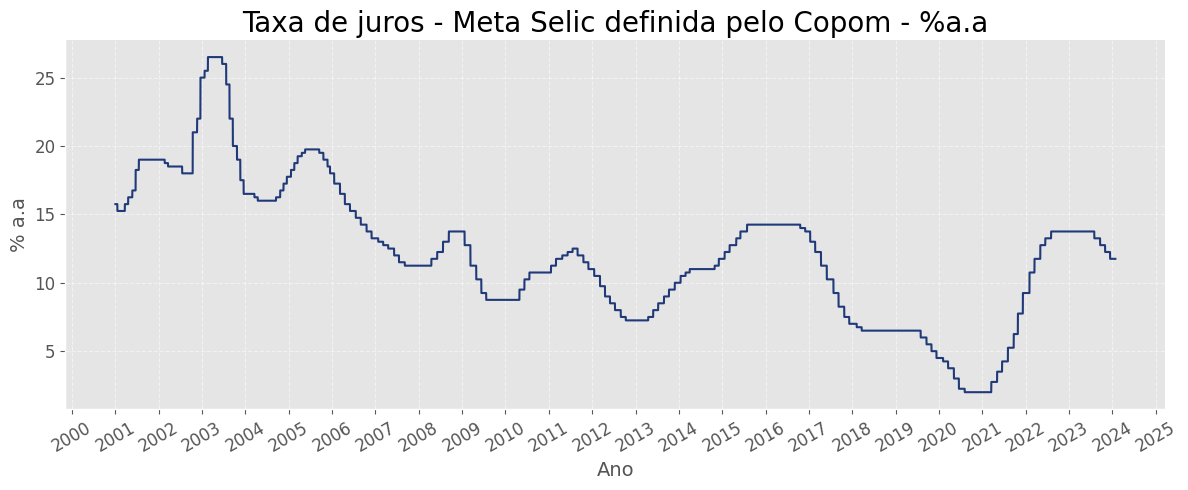

In [68]:
plot_series(selic_df, 'selic', title=r'Taxa de juros - Meta Selic definida pelo Copom - %a.a',
            ylabel=r'% a.a', xlabel='Ano', figsize=(12, 5))

Em resposta à crise de 2008, a taxa de juros (Selic), subiu. Já no período da pandemia, a taxa de juros caiu.

Explicação:
 - Crise: Aumento da taxa de juros para conter a inflação, que estava alta.
 - Pandemia: Redução da taxa de juros para estimular a economia, que estava em recessão.

## PIB (Produto Interno Bruto) - Brasil

**PIB Real**
Dados do IBGE, Tabela 6784 - Produto Interno Bruto, Produto Interno Bruto per capita, População residente e Deflator.<br>
Variável - PIB - valores correntes (Milhões de Reais)

**PIB Per Capta**
Tabela 6784 - Produto Interno Bruto, Produto Interno Bruto per capita, População residente e Deflator<br>
Variável - PIB per capita - valores correntes (Reais)<br>

Fonte: https://www.ibge.gov.br/explica/pib.php

In [69]:
pib = pd.read_excel('data/pib_ibge.xlsx', sheet_name='pib', index_col=0, decimal=',')

# ano as year
pib.index = pd.to_datetime(pib.index, format='%Y')

pib.head()

pib_milhoes_reais  pib_per_capta_reais
ano                                               
1996-01-01             854764              5219.36
1997-01-01             952089              5729.02
1998-01-01            1002351              5944.92
1999-01-01            1087710              6359.80
2000-01-01            1199092              6900.62

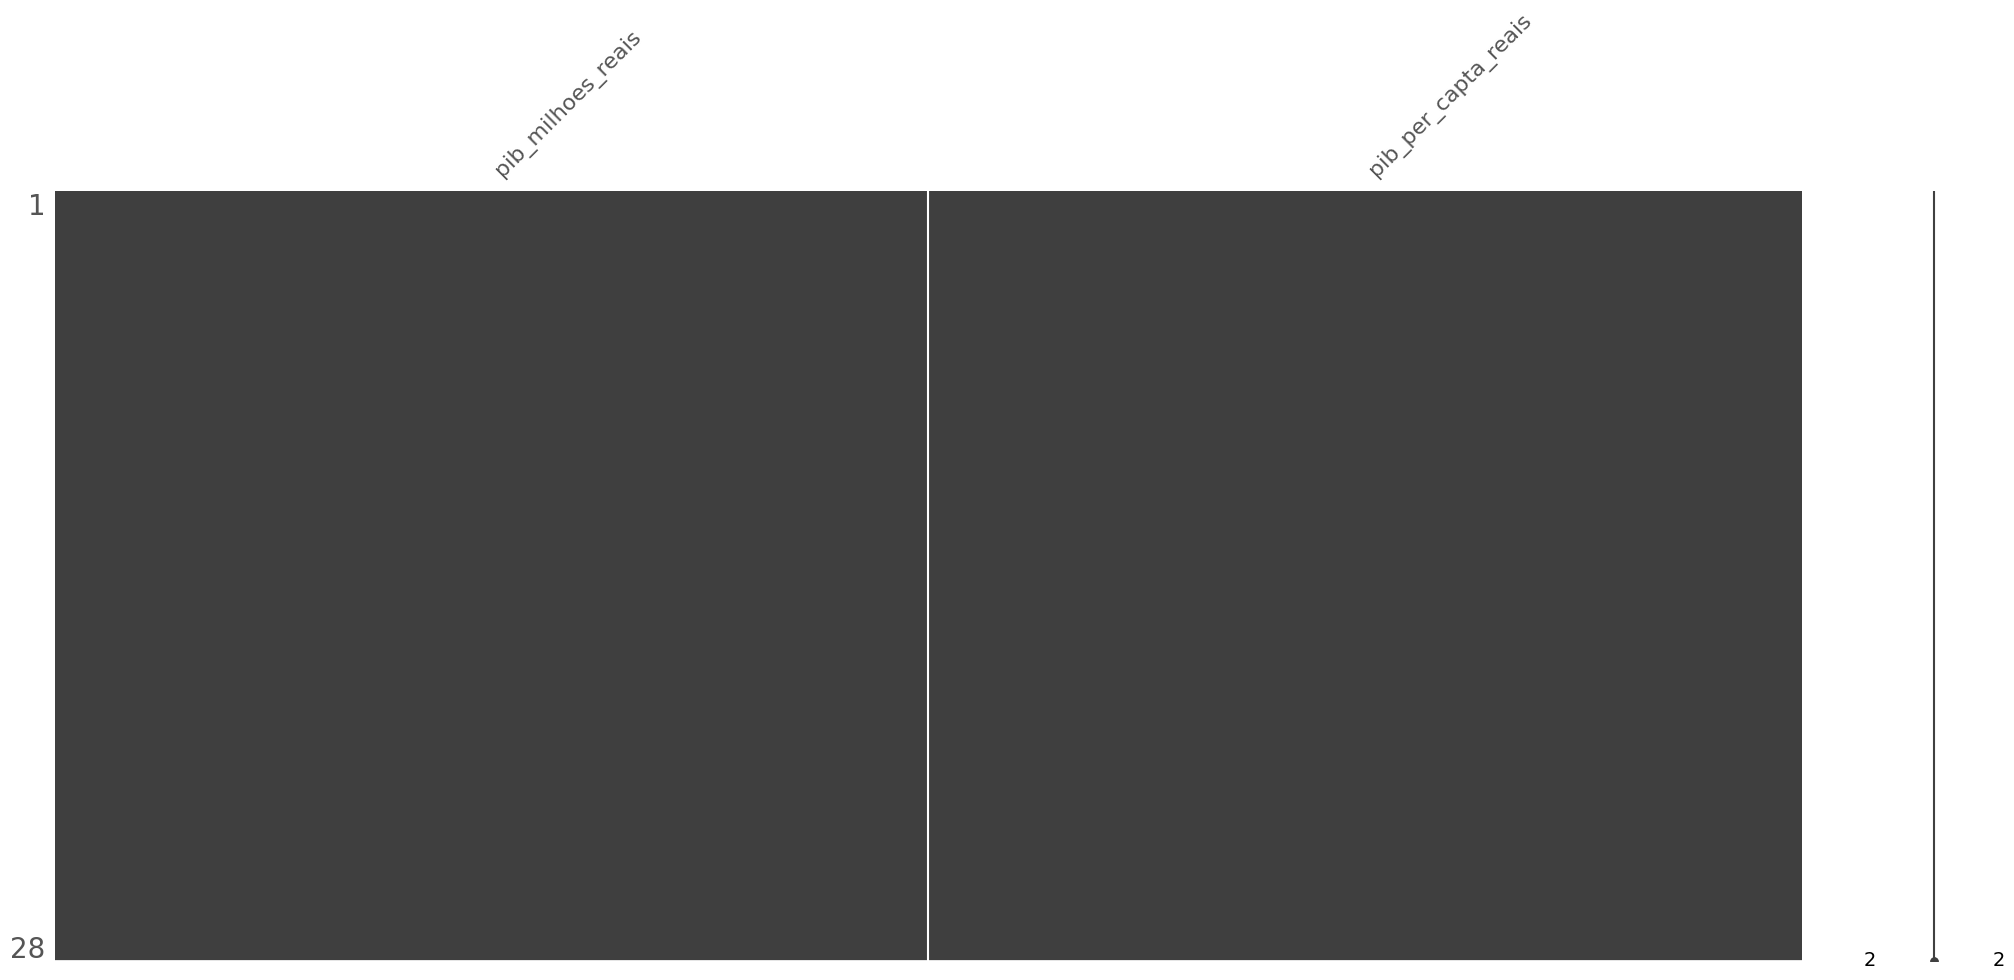

In [70]:
# missing values
msno.matrix(pib);

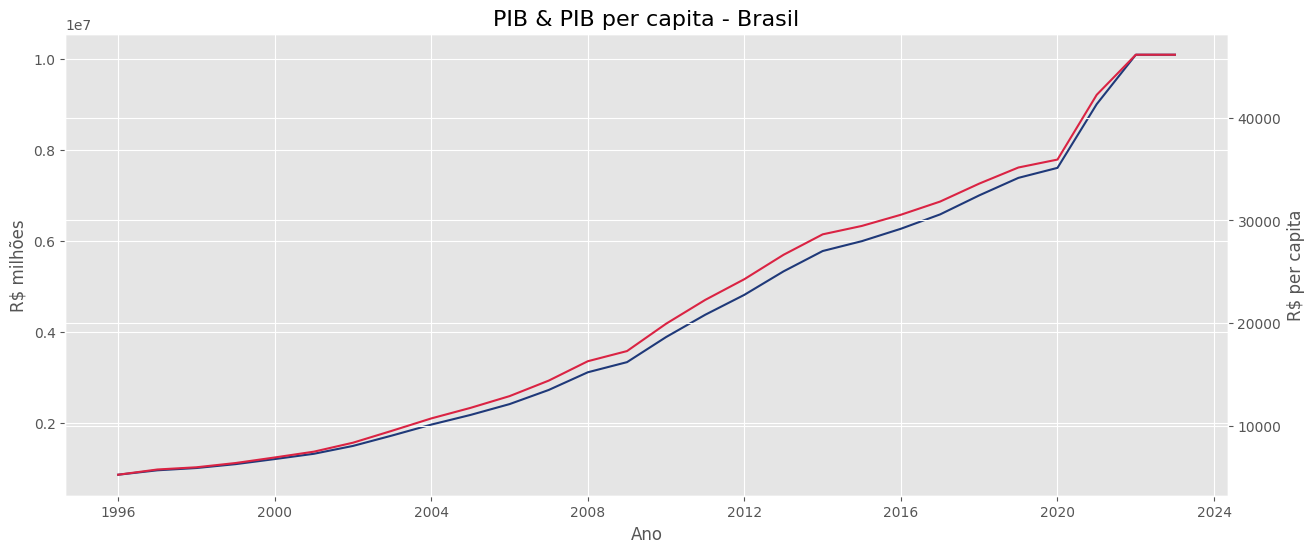

In [71]:
# compare both
fig, ax = plt.subplots(figsize=(15, 6))
# double ax
ax2 = ax.twinx()
# plot pib
sns.lineplot(data=pib['pib_milhoes_reais'], ax=ax, color='#1f3979') # PIB Total
# plot pib per capita
sns.lineplot(data=pib['pib_per_capta_reais'], ax=ax2, color='#da2343') # PIB per capita
# set title
ax.set_title('PIB & PIB per capita - Brasil', fontsize=16)
# set ylabel
ax.set_ylabel('R$ milhões', fontsize=12)
# set ylabel2
ax2.set_ylabel('R$ per capita', fontsize=12)
# set xlabel
ax.set_xlabel('Ano', fontsize=12)
plt.show()


O PIB é calculado pela soma de todos os bens e serviços finais produzidos em um país durante um determinado período. O PIB per capita é o PIB dividido pela população total do país. O PIB é um dos indicadores mais utilizados na macroeconomia, pois reflete a produção de bens e serviços de um país e, portanto, é um indicador do crescimento econômico. O plot para ambos segue tendência similar, então optamos por utilizar o PIB per capita, já que também é um indicador de crescimento econômico, mas que leva em consideração a população do país.

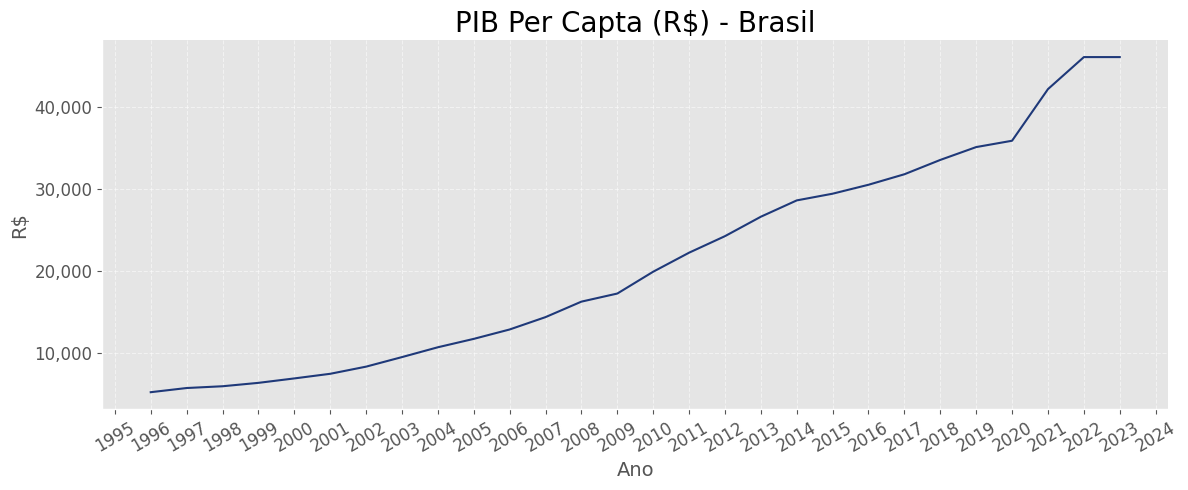

In [72]:
# plot series: pib per capita
plot_series(pib, 'pib_per_capta_reais', title='PIB Per Capta (R$) - Brasil',
            ylabel='R$', xlabel='Ano', figsize=(12, 5))

# arrumar função: se número de caracteres > 6, dividir por 1e6 e colocar 'milhões'

In [73]:
# take only pib per capita
pib = pib[['pib_per_capta_reais']]
# rename columns
pib.columns = ['pib_per_capta']

# filter from 2001
pib = pib[pib.index.year >= 2001]

pib.head()

pib_per_capta
ano                      
2001-01-01        7467.03
2002-01-01        8340.58
2003-01-01        9506.76
2004-01-01       10705.99
2005-01-01       11733.45

## Dólar

In [74]:
dolar_df = currency.get('USD', start='2001-01-01', end='2024-01-17')

dolar_df.head()

USD
Date              
2001-01-02  1.9384
2001-01-03  1.9422
2001-01-04  1.9357
2001-01-05  1.9484
2001-01-08  1.9524

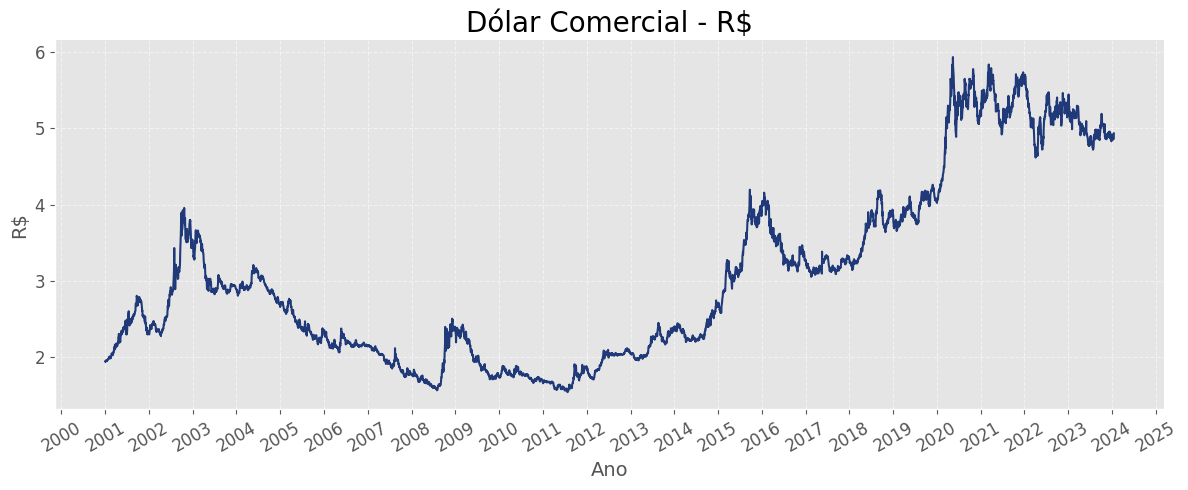

In [75]:
# plot dolar with func
plot_series(dolar_df, 'USD', title='Dólar Comercial - R$',
            ylabel='R$', xlabel='Ano', figsize=(12, 5))

In [76]:
# plotar todas as séries juntas, com plotly make_subplots
fig = make_subplots(rows=4, cols=1,
                    subplot_titles=('Ibovespa', 'Selic', 'PIB', 'Dólar', 'Desemprego'))

# Ibovespa
fig.add_trace(go.Scatter(x=ibovespa_df.index, 
                        y=ibovespa_df.close, 
                        hovertemplate='Fechamento: %{y:,.0f}',
                        line=dict(color='#1f3979', width=2)),
                        row=1, col=1)
# Selic
fig.add_trace(go.Scatter(x=selic_df.index, 
                        y=selic_df.selic, 
                        hovertemplate='Selic: %{y:.2f}%',
                        line=dict(color='#86261D', width=2)),
                        row=2, col=1)
# PIB
fig.add_trace(go.Scatter(x=pib.index, 
                        y=pib.pib_per_capta, 
                        hovertemplate='PIB Per Capta: R$%{y:,.0f}',
                        line=dict(color='#235207', width=2)),
                        row=3, col=1)
# Dólar
fig.add_trace(go.Scatter(x=dolar_df.index, 
                        y=dolar_df.USD, 
                        hovertemplate='Dólar: R$%{y:.2f}',
                        line=dict(color='#5C2666', width=2)),
                        row=4, col=1)

# fonte tamanho 16 no título
fig.update_layout(title=dict(text='Indicadores Econômicos', font=dict(size=18)),
                showlegend=False,
                template='plotly_white',
                hovermode='x unified',
                height=650, width=800)
# show plot
fig.show()
# exportar para html
fig.write_html('output/indicadores.html')

## Ativos Nacionais

Os cinco ativos com maior peso na composição do índice são Vale (VALE3), com 14,766%; Petrobras PN (PETR4), com 7,214%; Itaú Unibanco PN (ITUB4), com 6,428%; Petrobras ON (PETR3), com 4,467%; e B3 ON (B3SA3), com 3,579%.

In [77]:
# VALE3, PETR4, ITUB4, PETR3, B3SA3
vale = yf.download('VALE3.SA', start='2001-01-01')[['Close']]
petrobras_pn = yf.download('PETR4.SA', start='2001-01-01')[['Close']]
petrobras_on = yf.download('PETR3.SA', start='2001-01-01')[['Close']]
itau_pn = yf.download('ITUB4.SA', start='2001-01-01')[['Close']]
b3_on = yf.download('B3SA3.SA', start='2001-01-01')[['Close']]

# concat with names
ibov_stocks = pd.concat([vale, petrobras_pn, petrobras_on, itau_pn, b3_on], axis=1)
ibov_stocks.columns = ['vale', 'petrobras_pn', 'petrobras_on', 'itau_pn', 'b3_on']

ibov_stocks.head()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


vale  petrobras_pn  petrobras_on   itau_pn  b3_on
Date                                                             
2001-01-01  3.875000        5.7225           NaN  3.063211    NaN
2001-01-02  3.600000        5.9125       6.20125  2.963864    NaN
2001-01-03  3.833333        6.2125       6.63625  3.079935    NaN
2001-01-04  3.708333        6.2375       6.62625  3.129443    NaN
2001-01-05  3.666666        6.2500       6.53750  3.145835    NaN

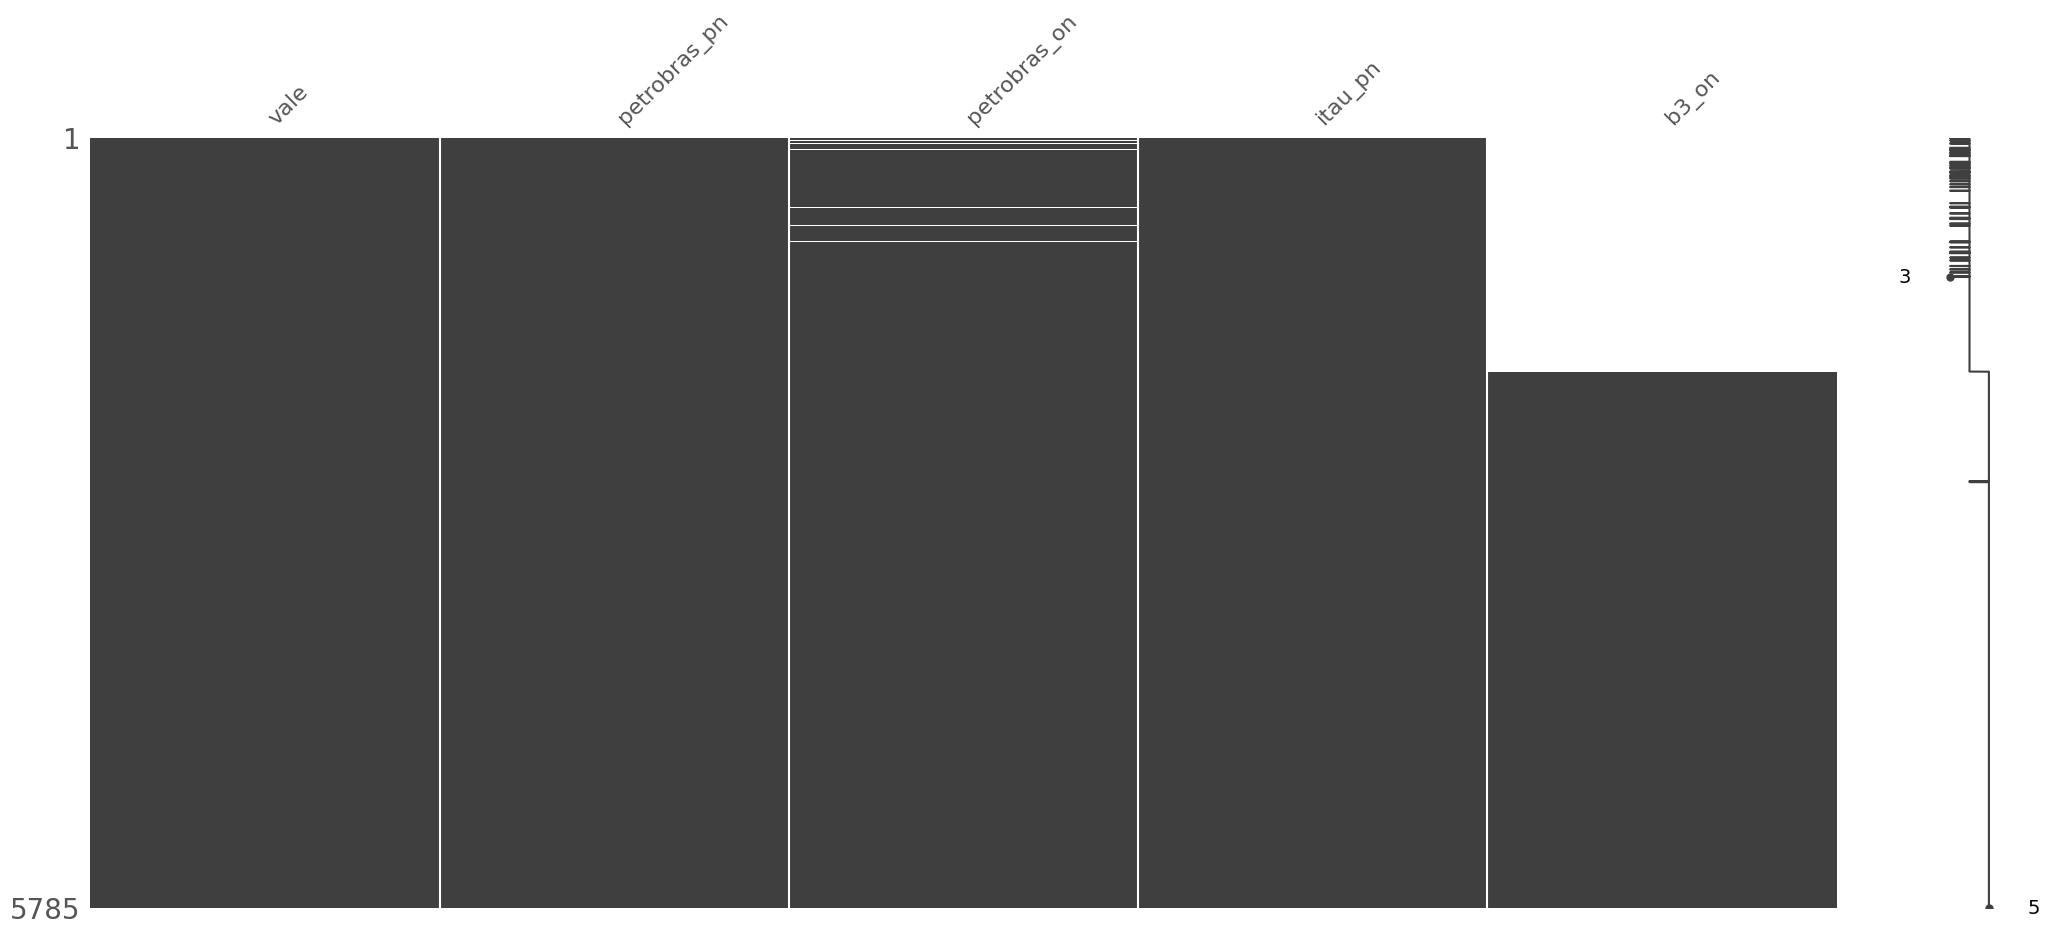

In [78]:
msno.matrix(ibov_stocks);

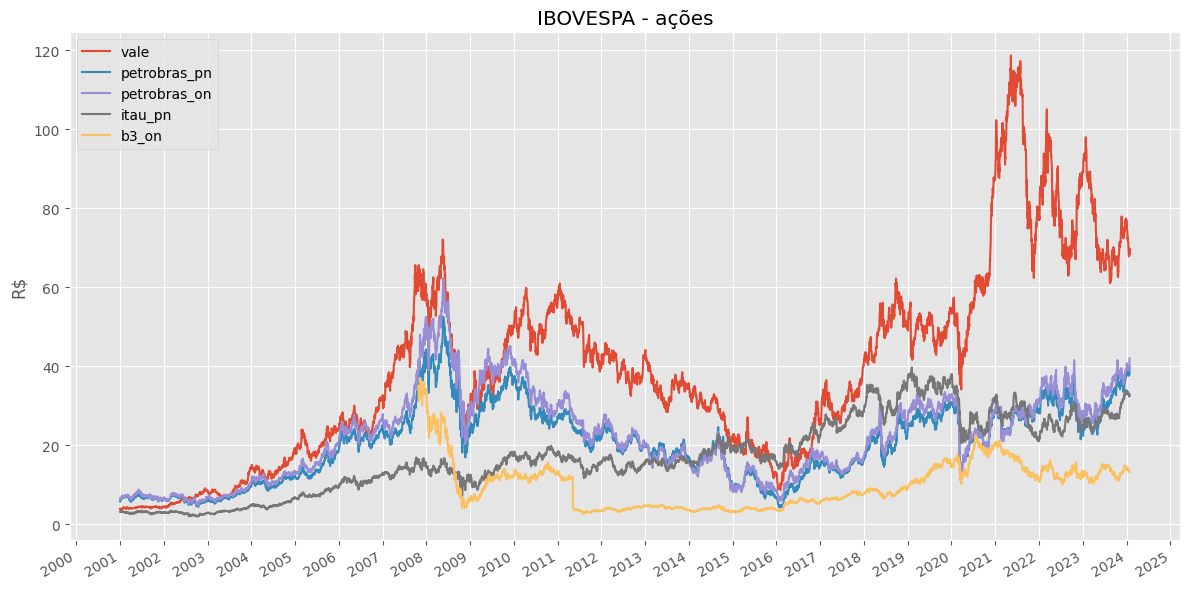

In [79]:
# plot
plt.style.use('ggplot')
ibov_stocks.plot(figsize = (12, 6))
plt.title('IBOVESPA - ações')
plt.xlabel('')
plt.ylabel('R$')
plt.legend(loc='upper left')
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.tight_layout()
plt.show()

## Ativos Internacionais

- índice S&P 500: composto por 500 ações negociadas nas bolsas de NY e NASDAQ
- índice Nikkei: composto por 225 ações negociadas na bolsa de Tóquio

In [80]:
# S&P 500
sp500_df = yf.download('^GSPC', start='2001-01-01')

sp500_df.head()

[*********************100%%**********************]  1 of 1 completed


Open         High          Low        Close    Adj Close  \
Date                                                                          
2001-01-02  1320.280029  1320.280029  1276.050049  1283.270020  1283.270020   
2001-01-03  1283.270020  1347.760010  1274.619995  1347.560059  1347.560059   
2001-01-04  1347.560059  1350.239990  1329.140015  1333.339966  1333.339966   
2001-01-05  1333.339966  1334.770020  1294.949951  1298.349976  1298.349976   
2001-01-08  1298.349976  1298.349976  1276.290039  1295.859985  1295.859985   

                Volume  
Date                    
2001-01-02  1129400000  
2001-01-03  1880700000  
2001-01-04  2131000000  
2001-01-05  1430800000  
2001-01-08  1115500000

In [81]:
# Nikkei
nikkei_df = yf.download('^N225', start='2001-01-01')

nikkei_df.head()

[*********************100%%**********************]  1 of 1 completed


Open          High           Low         Close  \
Date                                                                 
2001-01-04  13898.089844  13990.570312  13667.679688  13691.490234   
2001-01-05  13763.219727  13947.059570  13725.459961  13867.610352   
2001-01-09  13732.849609  13732.849609  13460.820312  13610.509766   
2001-01-10  13593.160156  13593.160156  13349.150391  13432.650391   
2001-01-11  13433.089844  13436.610352  13123.809570  13201.070312   

               Adj Close  Volume  
Date                              
2001-01-04  13691.490234       0  
2001-01-05  13867.610352       0  
2001-01-09  13610.509766       0  
2001-01-10  13432.650391       0  
2001-01-11  13201.070312       0

In [82]:
# concatenate all opens in one df, differentiating by column name
closes_df = pd.concat([ibovespa_df['close'], sp500_df['Close'], nikkei_df['Close']], axis=1)
closes_df.columns = ['ibovespa', 'sp500', 'nikkei']

closes_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6002 entries, 2001-01-02 to 2023-12-25
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ibovespa  5703 non-null   float64
 1   sp500     5803 non-null   float64
 2   nikkei    5649 non-null   float64
dtypes: float64(3)
memory usage: 187.6 KB


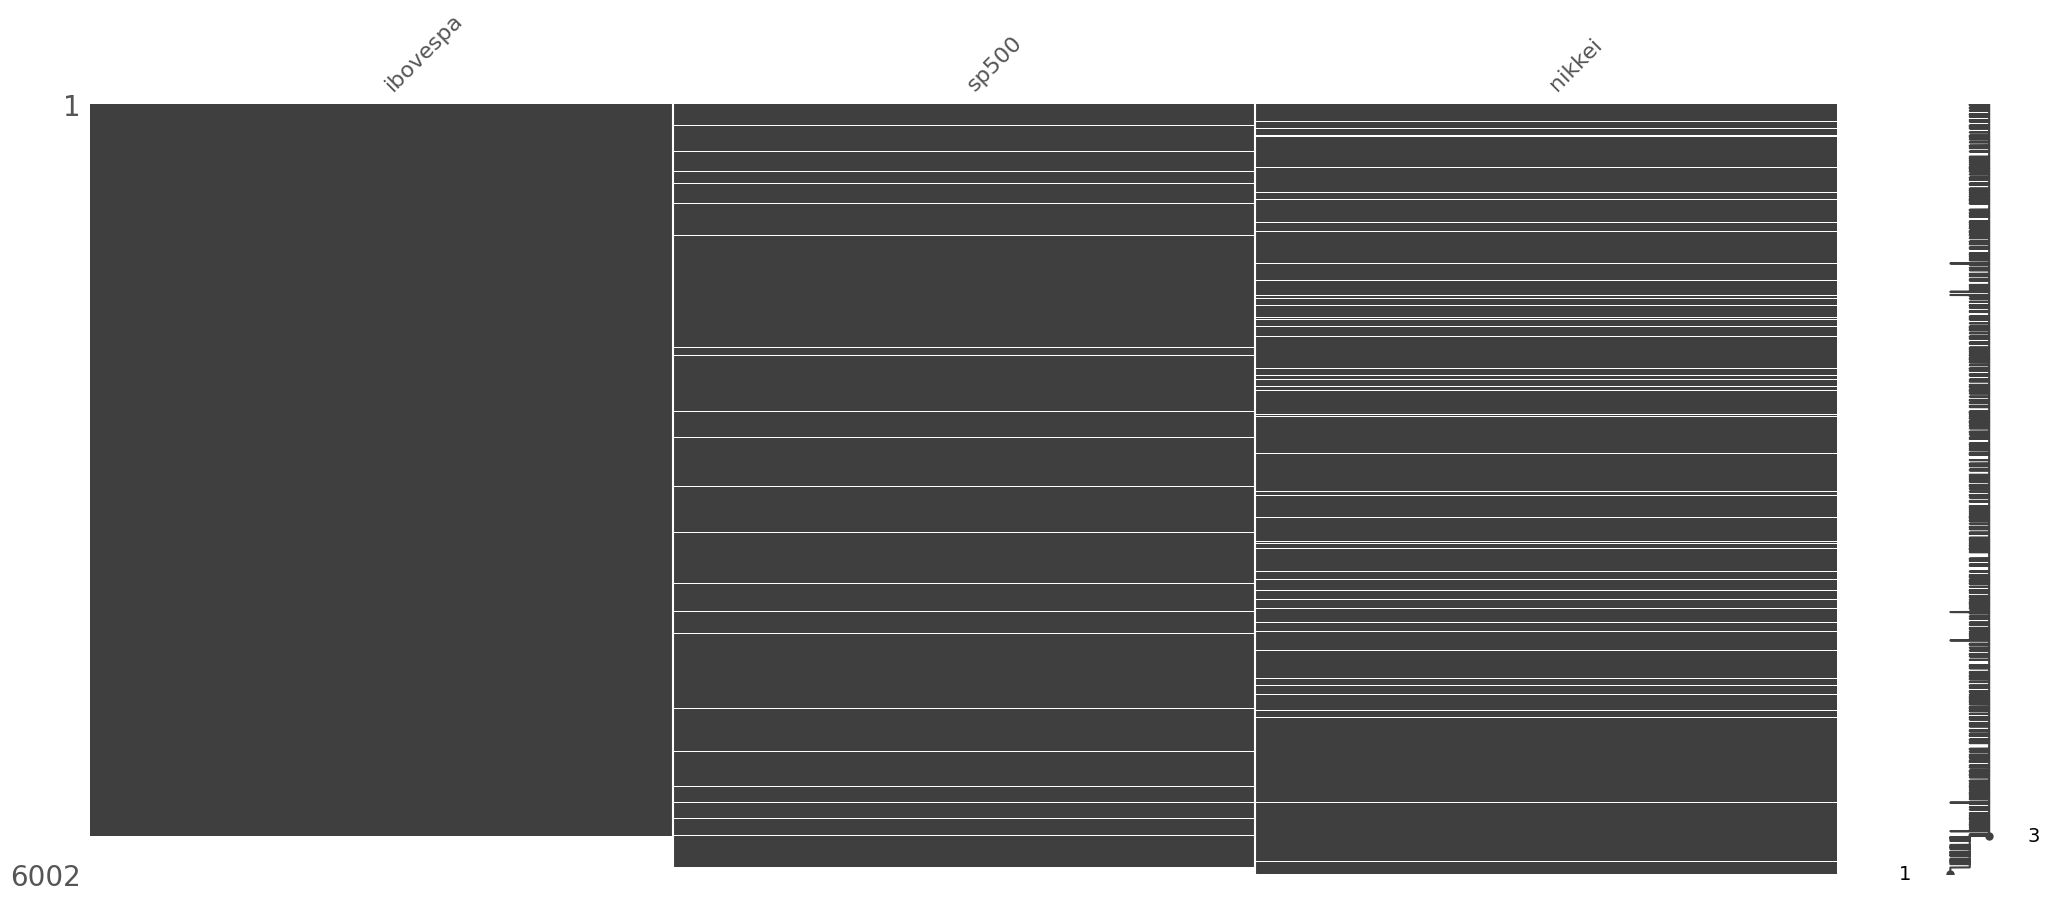

In [83]:
# missing
msno.matrix(closes_df);

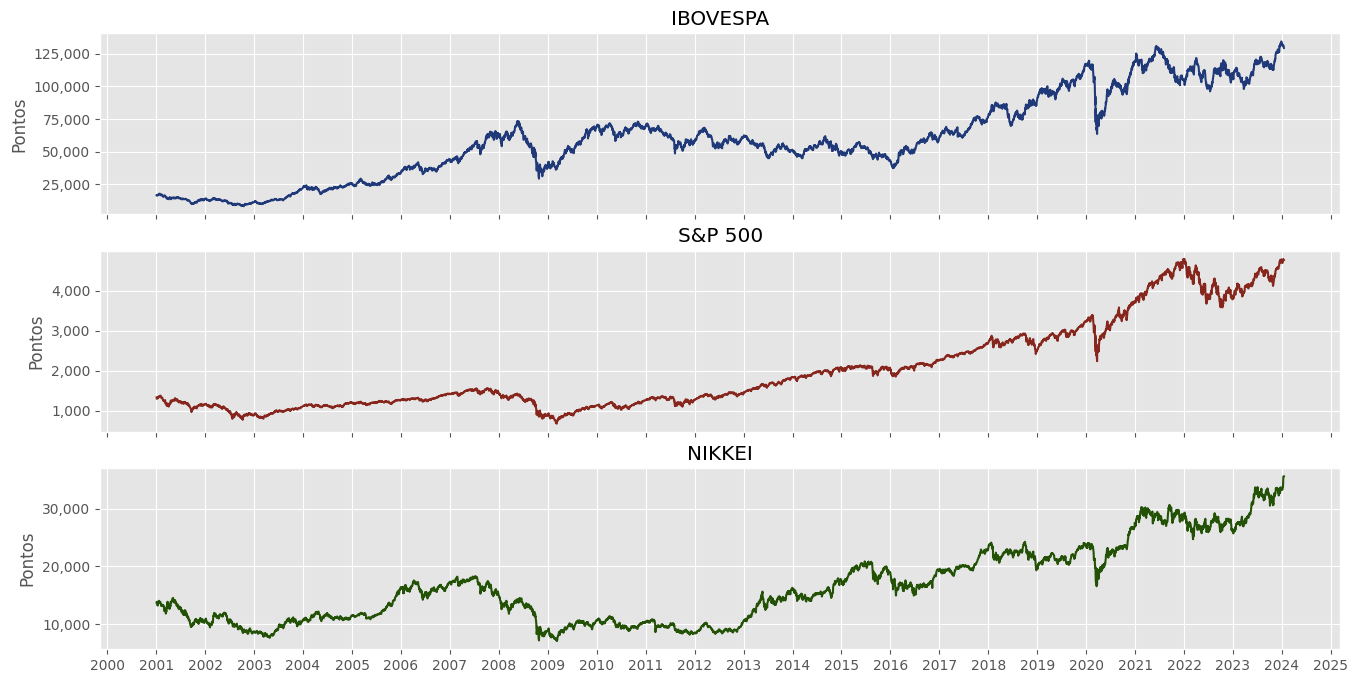

In [84]:
closes_df = closes_df.dropna()

# plot each in a different subplot
fig, ax = plt.subplots(3, 1, figsize=(16, 8), sharex=True)
ax[0].plot(closes_df['ibovespa'], color='#1f3979')
ax[0].set_ylabel('Pontos')
ax[1].plot(closes_df['sp500'], color='#86261D')
ax[1].set_ylabel('Pontos')
ax[2].plot(closes_df['nikkei'], color='#235207')
ax[2].set_ylabel('Pontos')
ax[0].set_title('IBOVESPA')
ax[1].set_title('S&P 500')
ax[2].set_title('NIKKEI')
# formal all y axis
for ax in fig.axes:
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
# all years 1 by 1
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.show()

In [85]:
# drop 18/01/2024 of nikkei - fuso horário do japão já tem fechamento do dia 17/01/2024
closes_df.drop(closes_df.index[-1], inplace=True)

# drop ibovespa from closes - para concatenar o dataframe adiante
closes_df.drop('ibovespa', axis=1, inplace=True)

In [86]:
closes_df.head(10)

sp500        nikkei
Date                                 
2001-01-04  1333.339966  13691.490234
2001-01-05  1298.349976  13867.610352
2001-01-09  1300.800049  13610.509766
2001-01-10  1313.270020  13432.650391
2001-01-11  1326.819946  13201.070312
2001-01-12  1318.550049  13347.740234
2001-01-16  1326.650024  13584.450195
2001-01-17  1329.469971  13667.629883
2001-01-18  1347.969971  13873.919922
2001-01-19  1342.540039  13989.120117

# Features

In [87]:
# para concatenar o ano, precisamos de um index com dias corridos
index_range = pd.date_range(start='2001', end='2023', freq='D')
# use the value of year in ano for filling all days of that year
pib = pib.reindex(index_range, method='ffill')

pib.head()

pib_per_capta
2001-01-01        7467.03
2001-01-02        7467.03
2001-01-03        7467.03
2001-01-04        7467.03
2001-01-05        7467.03

In [88]:
multi_df = ibovespa_df.copy()

# mesclar todos os dataframes ao multi_df
multi_df = pd.concat([multi_df, selic_df, dolar_df, pib, vale, petrobras_pn, petrobras_on, 
                        itau_pn, b3_on, closes_df], axis=1)

# se 'close' estiver NaN, deletar linha inteira (não é um dia útil)
multi_df = multi_df.dropna(subset=['close'], axis=0)

multi_df.columns = ['open', 'high', 'low', 'close', 'adj_close', 'volume', 'selic', 'dolar', 'pib_per_capta', 
                'vale', 'petrobras_pn', 'petrobras_on', 
                'itau_pn', 'b3_on','sp500', 'nikkei']

# remover colunas que dependem do fechamento do dia
multi_df.drop(['high', 'low', 'adj_close', 'volume'], axis=1, inplace=True)

# arrumar ordem de colunas por temas, para facilitar a análise
order = ['close', 'open', 'selic', 'dolar', 'pib_per_capta', 'sp500', 'nikkei', 
        'vale', 'petrobras_pn', 'petrobras_on', 'itau_pn', 'b3_on']

multi_df = multi_df[order]

multi_df.head()

close     open  selic   dolar  pib_per_capta        sp500  \
2001-01-02  15425.0  15242.0  15.75  1.9384        7467.03          NaN   
2001-01-03  16599.0  15425.0  15.75  1.9422        7467.03          NaN   
2001-01-04  16675.0  16597.0  15.75  1.9357        7467.03  1333.339966   
2001-01-05  16410.0  16679.0  15.75  1.9484        7467.03  1298.349976   
2001-01-08  16562.0  16398.0  15.75  1.9524        7467.03          NaN   

                  nikkei      vale  petrobras_pn  petrobras_on   itau_pn  \
2001-01-02           NaN  3.600000       5.91250       6.20125  2.963864   
2001-01-03           NaN  3.833333       6.21250       6.63625  3.079935   
2001-01-04  13691.490234  3.708333       6.23750       6.62625  3.129443   
2001-01-05  13867.610352  3.666666       6.25000       6.53750  3.145835   
2001-01-08           NaN  3.625000       6.17375       6.50000  3.079769   

            b3_on  
2001-01-02    NaN  
2001-01-03    NaN  
2001-01-04    NaN  
2001-01-05    NaN  
2001-01-08    NaN

In [89]:
# print sum of nulls by column
print(multi_df.isnull().sum())

close               0
open                0
selic               0
dolar               0
pib_per_capta     259
sp500             467
nikkei            467
vale                0
petrobras_pn        0
petrobras_on        8
itau_pn             0
b3_on            1694
dtype: int64


In [90]:
multi_df

close      open  selic   dolar  pib_per_capta        sp500  \
2001-01-02   15425.0   15242.0  15.75  1.9384        7467.03          NaN   
2001-01-03   16599.0   15425.0  15.75  1.9422        7467.03          NaN   
2001-01-04   16675.0   16597.0  15.75  1.9357        7467.03  1333.339966   
2001-01-05   16410.0   16679.0  15.75  1.9484        7467.03  1298.349976   
2001-01-08   16562.0   16398.0  15.75  1.9524        7467.03          NaN   
...              ...       ...    ...     ...            ...          ...   
2024-01-10  130841.0  131447.0  11.75  4.8901            NaN  4783.450195   
2024-01-11  130649.0  130841.0  11.75  4.8794            NaN  4780.240234   
2024-01-12  130988.0  130652.0  11.75  4.8543            NaN  4783.830078   
2024-01-15  131521.0  130988.0  11.75  4.8765            NaN          NaN   
2024-01-16  129294.0  131515.0  11.75  4.9038            NaN          NaN   

                  nikkei       vale  petrobras_pn  petrobras_on    itau_pn  \
2001-01-02           NaN   3.600000      5.912500      6.201250   2.963864   
2001-01-03           NaN   3.833333      6.212500      6.636250   3.079935   
2001-01-04  13691.490234   3.708333      6.237500      6.626250   3.129443   
2001-01-05  13867.610352   3.666666      6.250000      6.537500   3.145835   
2001-01-08           NaN   3.625000      6.173750      6.500000   3.079769   
...                  ...        ...           ...           ...        ...   
2024-01-10  34441.718750  72.230003     37.750000     39.029999  33.290001   
2024-01-11  35049.859375  72.610001     38.070000     39.430000  33.349998   
2024-01-12  35577.109375  71.690002     38.169998     39.639999  33.389999   
2024-01-15           NaN  71.550003     38.580002     40.040001  33.450001   
2024-01-16           NaN  70.620003     38.099998     39.599998  32.980000   

            b3_on  
2001-01-02    NaN  
2001-01-03    NaN  
2001-01-04    NaN  
2001-01-05    NaN  
2001-01-08    NaN  
...           ...  
2024-01-10  13.92  
2024-01-11  13.95  
2024-01-12  14.10  
2024-01-15  14.13  
2024-01-16  13.98  

[5703 rows x 12 columns]

In [91]:
# locate first null in pib
multi_df.loc[~multi_df.pib_per_capta.isna()]

close      open  selic   dolar  pib_per_capta        sp500  \
2001-01-02   15425.0   15242.0  15.75  1.9384        7467.03          NaN   
2001-01-03   16599.0   15425.0  15.75  1.9422        7467.03          NaN   
2001-01-04   16675.0   16597.0  15.75  1.9357        7467.03  1333.339966   
2001-01-05   16410.0   16679.0  15.75  1.9484        7467.03  1298.349976   
2001-01-08   16562.0   16398.0  15.75  1.9524        7467.03          NaN   
...              ...       ...    ...     ...            ...          ...   
2022-12-23  109698.0  107552.0  13.75  5.1445       46154.60  3844.820068   
2022-12-26  108738.0  109699.0  13.75  5.1872       46154.60          NaN   
2022-12-27  108347.0  108739.0  13.75  5.2832       46154.60  3829.250000   
2022-12-28  110237.0  108578.0  13.75  5.2736       46154.60  3783.219971   
2022-12-29  110031.0  110237.0  13.75  5.2177       46154.60  3849.280029   

                  nikkei       vale  petrobras_pn  petrobras_on    itau_pn  \
2001-01-02           NaN   3.600000      5.912500      6.201250   2.963864   
2001-01-03           NaN   3.833333      6.212500      6.636250   3.079935   
2001-01-04  13691.490234   3.708333      6.237500      6.626250   3.129443   
2001-01-05  13867.610352   3.666666      6.250000      6.537500   3.145835   
2001-01-08           NaN   3.625000      6.173750      6.500000   3.079769   
...                  ...        ...           ...           ...        ...   
2022-12-23  26235.250000  86.320000     25.120001     28.559999  25.190001   
2022-12-26           NaN  87.110001     24.940001     28.469999  24.690001   
2022-12-27  26447.869141  89.190002     25.110001     28.660000  24.549999   
2022-12-28  26340.500000  88.989998     24.799999     28.500000  25.049999   
2022-12-29  26093.669922  88.879997     24.500000     28.040001  25.000000   

            b3_on  
2001-01-02    NaN  
2001-01-03    NaN  
2001-01-04    NaN  
2001-01-05    NaN  
2001-01-08    NaN  
...           ...  
2022-12-23  13.35  
2022-12-26  13.42  
2022-12-27  12.95  
2022-12-28  13.40  
2022-12-29  13.21  

[5444 rows x 12 columns]

In [92]:
# pib é um dado mensal, então podemos usar o valor daquele mês/ano para preencher os valores NaN
multi_df['pib_per_capta'] = multi_df['pib_per_capta'].fillna(method='ffill')
# para os demais dados, podemos usar o valor do dia anterior para preencher os valores NaN
multi_df = multi_df.fillna(method='bfill')
# b3 tem muito poucos dados faltantes, além disso, pode ocasionar overfitting
multi_df.drop('b3_on', axis=1, inplace=True)

print(multi_df.isnull().sum())

close            0
open             0
selic            0
dolar            0
pib_per_capta    0
sp500            2
nikkei           2
vale             0
petrobras_pn     0
petrobras_on     0
itau_pn          0
dtype: int64


In [93]:
multi_df

close      open  selic   dolar  pib_per_capta        sp500  \
2001-01-02   15425.0   15242.0  15.75  1.9384        7467.03  1333.339966   
2001-01-03   16599.0   15425.0  15.75  1.9422        7467.03  1333.339966   
2001-01-04   16675.0   16597.0  15.75  1.9357        7467.03  1333.339966   
2001-01-05   16410.0   16679.0  15.75  1.9484        7467.03  1298.349976   
2001-01-08   16562.0   16398.0  15.75  1.9524        7467.03  1300.800049   
...              ...       ...    ...     ...            ...          ...   
2024-01-10  130841.0  131447.0  11.75  4.8901       46154.60  4783.450195   
2024-01-11  130649.0  130841.0  11.75  4.8794       46154.60  4780.240234   
2024-01-12  130988.0  130652.0  11.75  4.8543       46154.60  4783.830078   
2024-01-15  131521.0  130988.0  11.75  4.8765       46154.60          NaN   
2024-01-16  129294.0  131515.0  11.75  4.9038       46154.60          NaN   

                  nikkei       vale  petrobras_pn  petrobras_on    itau_pn  
2001-01-02  13691.490234   3.600000      5.912500      6.201250   2.963864  
2001-01-03  13691.490234   3.833333      6.212500      6.636250   3.079935  
2001-01-04  13691.490234   3.708333      6.237500      6.626250   3.129443  
2001-01-05  13867.610352   3.666666      6.250000      6.537500   3.145835  
2001-01-08  13610.509766   3.625000      6.173750      6.500000   3.079769  
...                  ...        ...           ...           ...        ...  
2024-01-10  34441.718750  72.230003     37.750000     39.029999  33.290001  
2024-01-11  35049.859375  72.610001     38.070000     39.430000  33.349998  
2024-01-12  35577.109375  71.690002     38.169998     39.639999  33.389999  
2024-01-15           NaN  71.550003     38.580002     40.040001  33.450001  
2024-01-16           NaN  70.620003     38.099998     39.599998  32.980000  

[5703 rows x 11 columns]

In [94]:
multi_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5703 entries, 2001-01-02 to 2024-01-16
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   close          5703 non-null   float64
 1   open           5703 non-null   float64
 2   selic          5703 non-null   float64
 3   dolar          5703 non-null   float64
 4   pib_per_capta  5703 non-null   float64
 5   sp500          5701 non-null   float64
 6   nikkei         5701 non-null   float64
 7   vale           5703 non-null   float64
 8   petrobras_pn   5703 non-null   float64
 9   petrobras_on   5703 non-null   float64
 10  itau_pn        5703 non-null   float64
dtypes: float64(11)
memory usage: 534.7 KB


# EDA

## Univariative Analysis - Ibovespa

In [95]:
multi_df['close'].describe().round(2)

count      5703.00
mean      59969.01
std       31871.18
min        8371.00
25%       37835.00
50%       56873.00
75%       77159.00
max      134194.00
Name: close, dtype: float64

In [96]:
# describe by year
multi_df['close'].groupby(multi_df.index.year)\
                    .describe().round(2)

count       mean       std       min        25%       50%        75%  \
2001  245.0   14046.70   1889.64   10006.0   12959.00   14068.0   15061.00   
2002  249.0   11445.94   1723.48    8371.0    9892.00   10967.0   13090.00   
2003  250.0   14449.32   3253.52    9995.0   11956.75   13500.5   16879.50   
2004  249.0   22314.29   1767.89   17604.0   21337.00   22426.0   23289.00   
2005  249.0   27551.22   2786.06   23610.0   25226.00   26702.0   29770.00   
2006  246.0   38037.77   2438.95   32848.0   36440.75   37573.0   39269.00   
2007  245.0   53114.10   7029.31   41179.0   46288.00   52922.0   59069.00   
2008  249.0   55260.93  11764.37   29435.0   46145.00   59365.0   63792.00   
2009  246.0   52750.86   9910.39   36235.0   43001.00   52112.5   61111.00   
2010  247.0   67258.32   3040.81   58192.0   65150.50   67815.0   69578.00   
2011  249.0   61206.78   5574.37   48668.0   56534.00   61194.0   66440.00   
2012  244.0   59578.75   3925.63   52481.0   56700.25   59199.0   62104.25   
2013  248.0   53670.43   4030.43   45044.0   50905.00   53961.5   56034.50   
2014  248.0   52729.67   3881.07   44966.0   49970.50   52631.5   55595.25   
2015  246.0   49779.88   3524.69   43200.0   47094.25   49089.5   52880.50   
2016  249.0   53258.41   7163.43   37497.0   49422.00   53631.0   58697.00   
2017  247.0   68063.51   4911.21   59589.0   64204.50   66278.0   72857.00   
2018  245.0   81639.09   4885.16   69815.0   77995.00   83118.0   85547.00   
2019  248.0  100658.49   5811.43   89993.0   96009.50   99987.5  104483.25   
2020  248.0   98674.44  13616.57   63570.0   93398.75  100369.0  107756.25   
2021  247.0  116892.49   7590.70  100775.0  111145.50  117904.0  122129.00   
2022  250.0  109619.00   5662.75   96121.0  106523.50  110375.5  113395.00   
2023  248.0  114194.02   7899.70   97926.0  108240.50  114879.5  118793.00   
2024   11.0  131449.73   1033.58  129294.0  130914.50  131447.0  132225.00   

           max  
2001   17889.0  
2002   14471.0  
2003   22236.0  
2004   26196.0  
2005   33629.0  
2006   44526.0  
2007   65791.0  
2008   73517.0  
2009   69349.0  
2010   72996.0  
2011   71633.0  
2012   68394.0  
2013   63312.0  
2014   61896.0  
2015   58052.0  
2016   64925.0  
2017   76990.0  
2018   89820.0  
2019  117203.0  
2020  119528.0  
2021  130776.0  
2022  121570.0  
2023  134194.0  
2024  132834.0

In [97]:
# compare months and years
ibov_month_year = multi_df['close']\
                    .groupby([multi_df['close']\
                        .index.month, multi_df['close']\
                            .index.year]).describe().round(2)

# reset index
ibov_month_year.reset_index(inplace=True)

# rename columns
ibov_month_year.rename(columns={'level_0': 'month', 'level_1': 'year'}, inplace=True)

# salvar em dataframe
ibov_month_year.to_csv('output/ibov_month_year.csv')

ibov_month_year

month  year  count       mean      std       min        25%       50%  \
0        1  2001   21.0   17120.48   619.19   15425.0   16721.00   17024.0   
1        1  2002   21.0   13401.43   576.77   12501.0   13011.00   13232.0   
2        1  2003   22.0   11486.23   555.68   10517.0   10991.25   11625.5   
3        1  2004   21.0   23412.90   635.23   21851.0   23155.00   23471.0   
4        1  2005   20.0   24432.90   462.86   23610.0   24170.75   24368.5   
..     ...   ...    ...        ...      ...       ...        ...       ...   
272     12  2019   19.0  112741.42  2590.68  108956.0  110818.00  112200.0   
273     12  2020   20.0  115647.00  2550.92  111335.0  113611.50  115669.5   
274     12  2021   21.0  105894.19  1749.47  100775.0  104891.00  105531.0   
275     12  2022   21.0  107561.48  2649.28  102825.0  105264.00  107689.0   
276     12  2023   19.0  129733.95  2927.33  125623.0  126909.50  130197.0   

           75%       max  
0     17673.00   17889.0  
1     13872.00   14379.0  
2     11942.00   12243.0  
3     23852.00   24350.0  
4     24705.75   25722.0  
..         ...       ...  
272  115126.00  117203.0  
273  117879.50  119475.0  
274  107370.00  108212.0  
275  109533.00  111924.0  
276  132016.50  134194.0  

[277 rows x 10 columns]

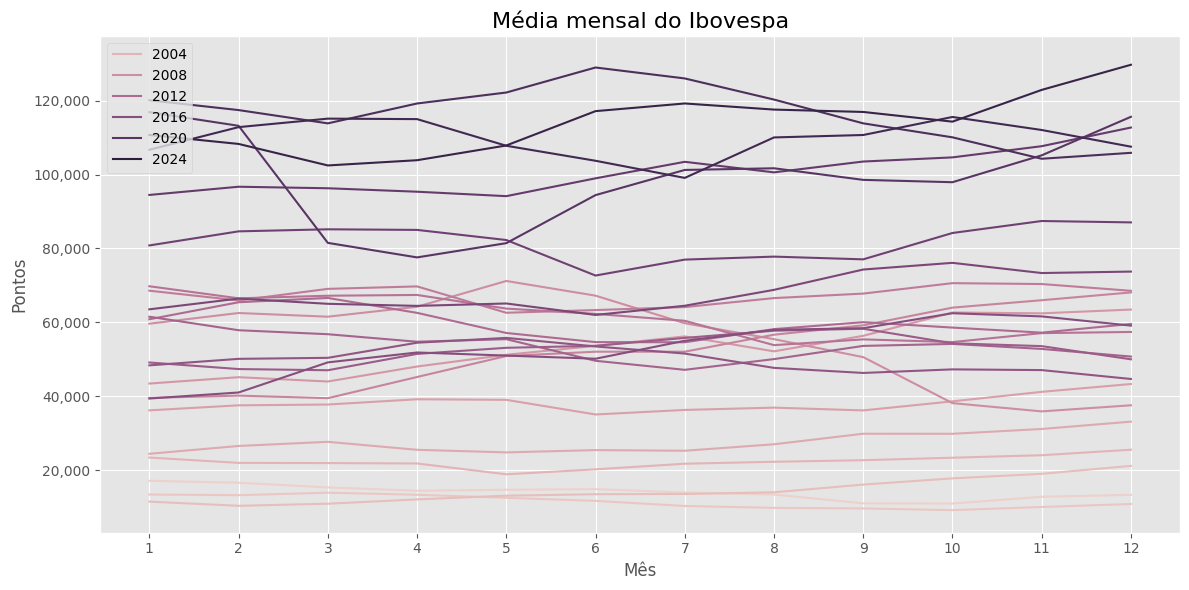

In [98]:
# plot mean for each month and year
plt.figure(figsize=(12, 6))
sns.lineplot(data=ibov_month_year, x='month', y='mean', hue='year')
plt.title('Média mensal do Ibovespa', fontsize=16)
plt.xlabel('Mês', fontsize=12)
plt.ylabel('Pontos', fontsize=12)
plt.legend(loc='upper left')
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.tight_layout()
plt.show()

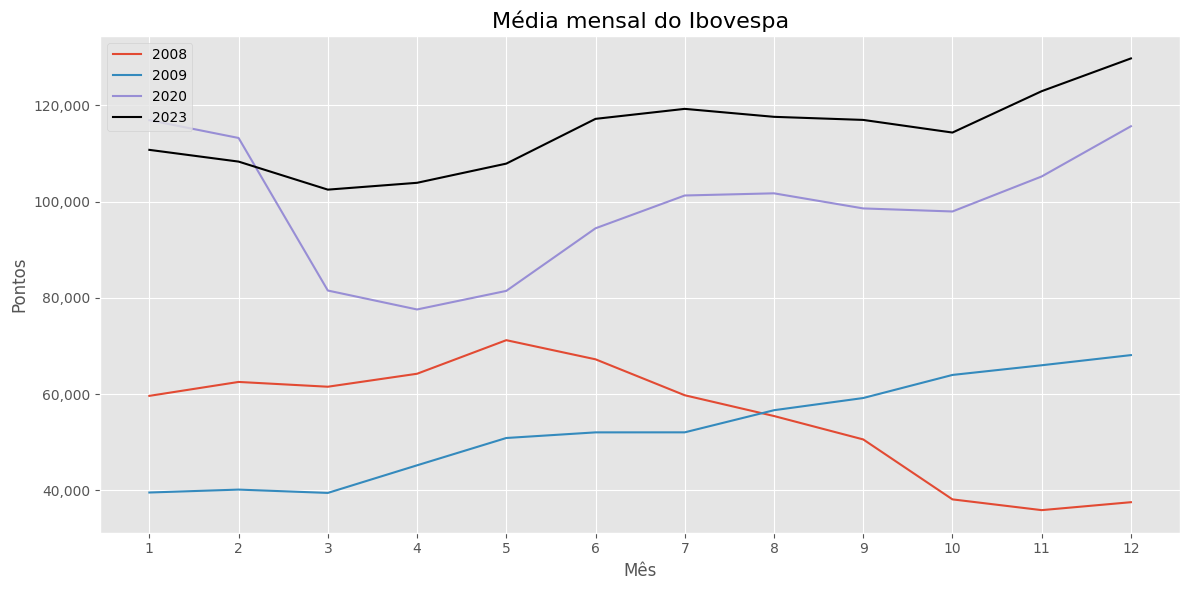

In [99]:
# plotar 2008, 2020, 2023
plt.figure(figsize=(12, 6))
sns.lineplot(data=ibov_month_year[ibov_month_year['year'] == 2008], x='month', y='mean', label='2008')
sns.lineplot(data=ibov_month_year[ibov_month_year['year'] == 2009], x='month', y='mean', label='2009')
sns.lineplot(data=ibov_month_year[ibov_month_year['year'] == 2020], x='month', y='mean', label='2020')
sns.lineplot(data=ibov_month_year[ibov_month_year['year'] == 2023], x='month', y='mean', label='2023', color='black') # arrumar cores
plt.title('Média mensal do Ibovespa', fontsize=16)
plt.xlabel('Mês', fontsize=12)
plt.ylabel('Pontos', fontsize=12)
plt.legend(loc='upper left')
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.tight_layout()
plt.show()

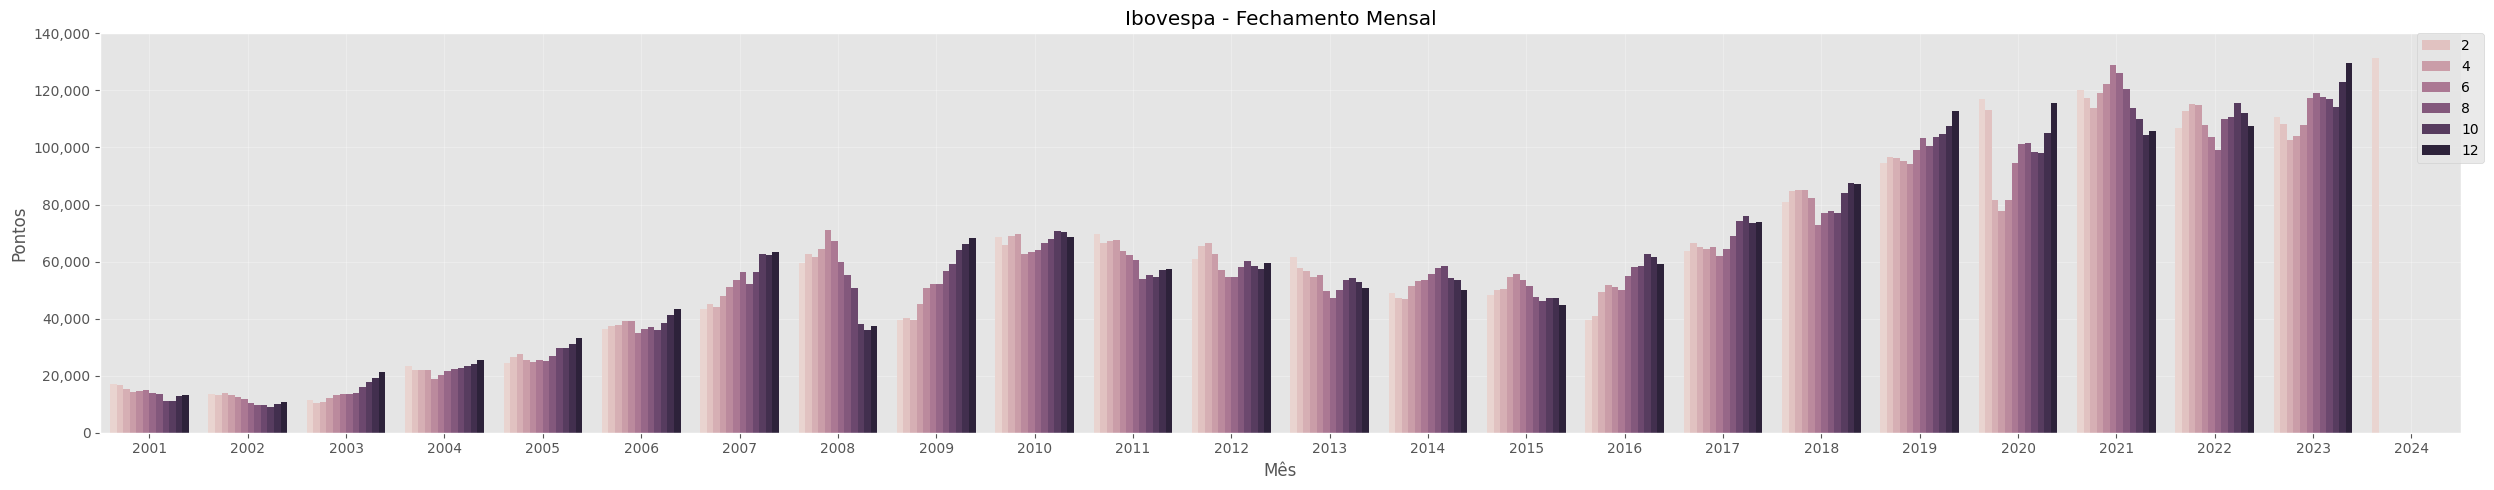

In [100]:
# plot bar for each month in same plot
plt.figure(figsize=(25, 5))
sns.barplot(x=multi_df.index.year, y=multi_df['close'], hue=multi_df.index.month, errorbar=None)
plt.title('Ibovespa - Fechamento Mensal')
plt.xlabel('Mês')
plt.ylabel('Pontos')
plt.grid(True, alpha=0.3)
# legend outside plot
plt.legend(bbox_to_anchor=(1.01, 1), borderaxespad=0)
# format y values
plt.yticks(np.arange(0, 160000, 20000), ['{:,}'.format(int(x)) for x in np.arange(0, 160000, 20000)])
plt.tight_layout()
plt.show()

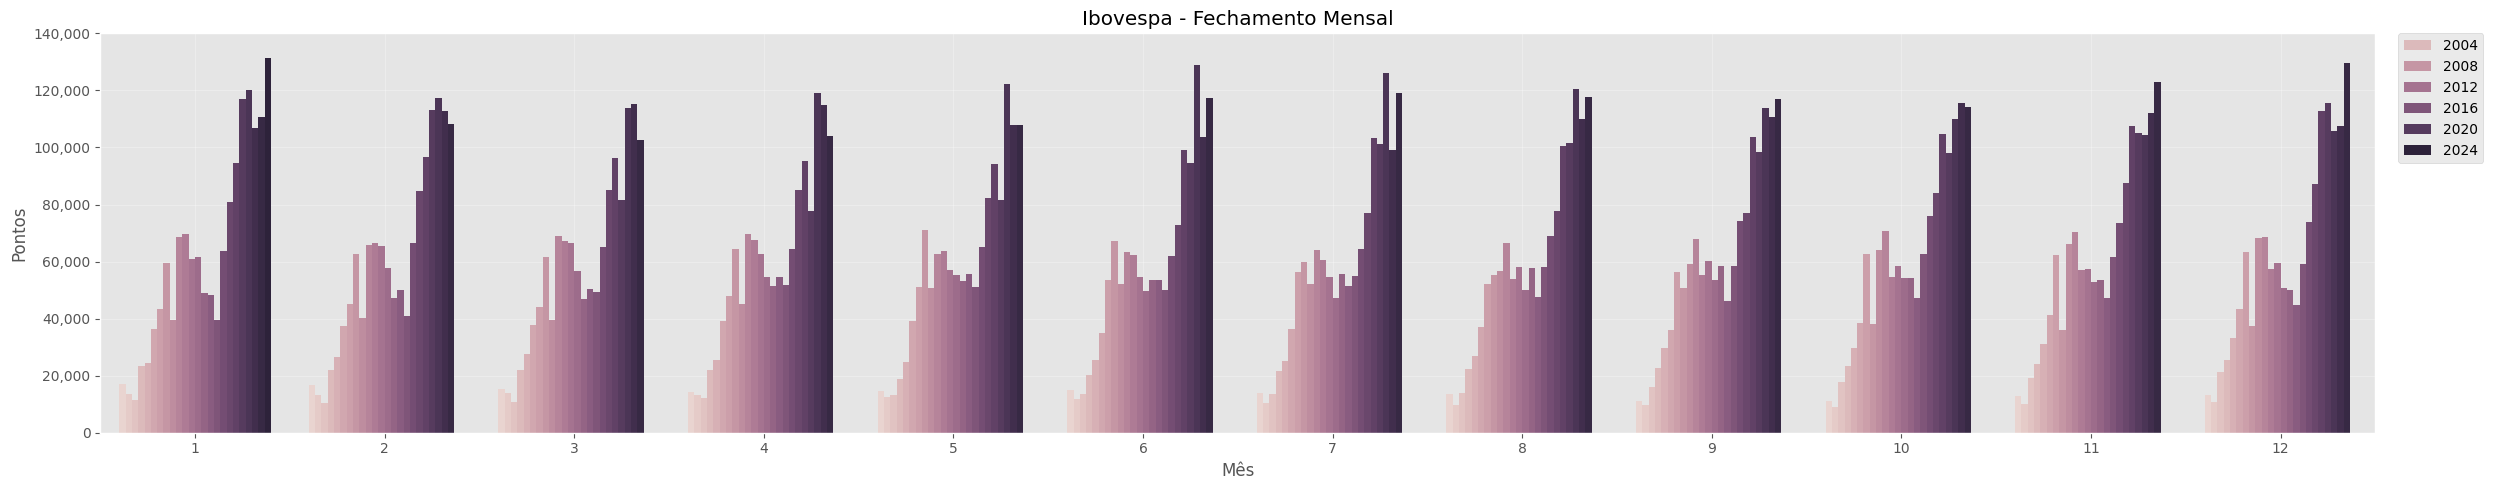

In [101]:
# plot bar for each month in same plot
plt.figure(figsize=(25, 5))
sns.barplot(x=multi_df.index.month, y=multi_df['close'], hue=multi_df.index.year, errorbar=None)
plt.title('Ibovespa - Fechamento Mensal')
plt.xlabel('Mês')
plt.ylabel('Pontos')
plt.grid(True, alpha=0.3)
# legend outside plot
plt.legend(bbox_to_anchor=(1.01, 1), borderaxespad=0)
# format y values
plt.yticks(np.arange(0, 160000, 20000), ['{:,}'.format(int(x)) for x in np.arange(0, 160000, 20000)])
plt.tight_layout()
plt.show()

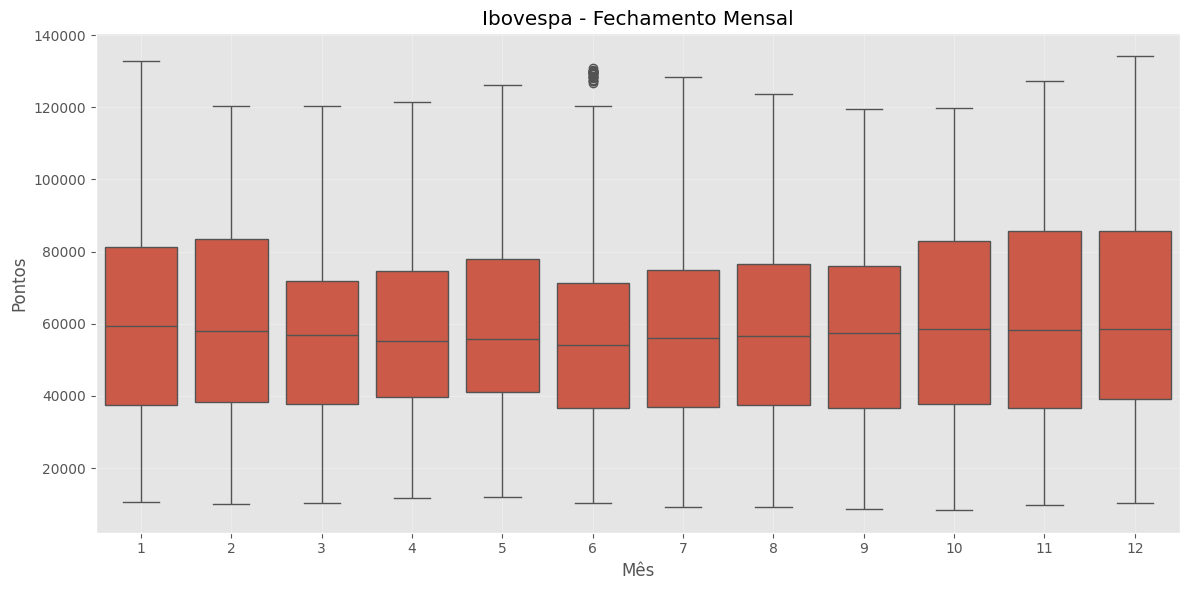

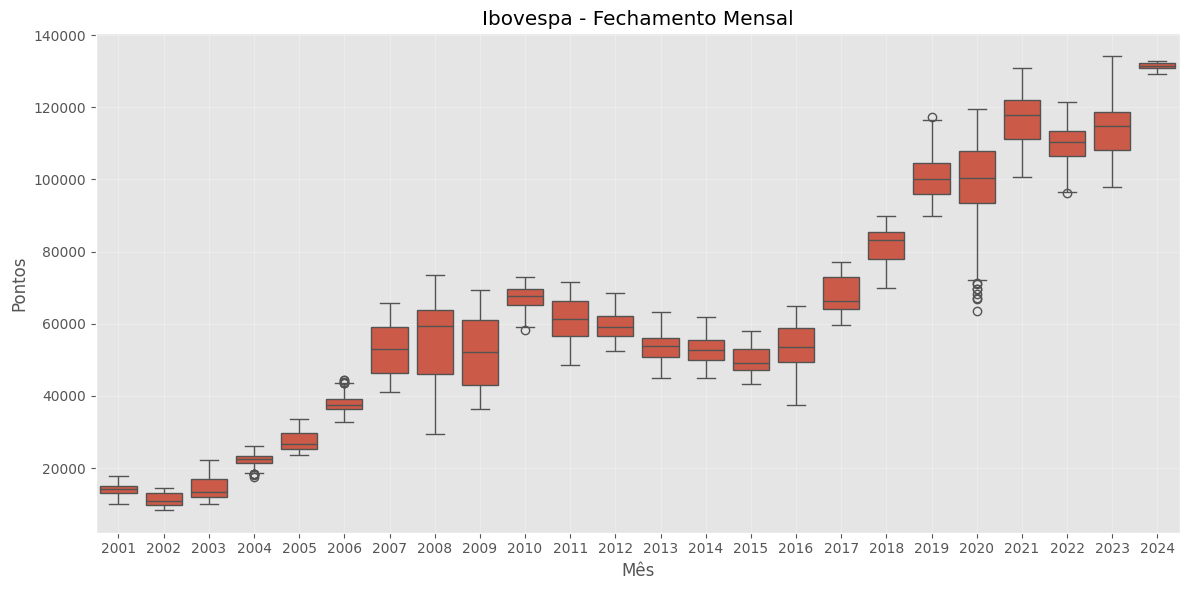

In [102]:
plt.figure(figsize=(12, 6))
sns.boxplot(x=multi_df.index.month, y=multi_df['close'])
plt.title('Ibovespa - Fechamento Mensal')
plt.xlabel('Mês')
plt.ylabel('Pontos')
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.figure(figsize=(12, 6))
sns.boxplot(x=multi_df.index.year, y=multi_df['close'])
plt.title('Ibovespa - Fechamento Mensal')
plt.xlabel('Mês')
plt.ylabel('Pontos')
plt.grid(True, alpha=0.3)
plt.tight_layout()

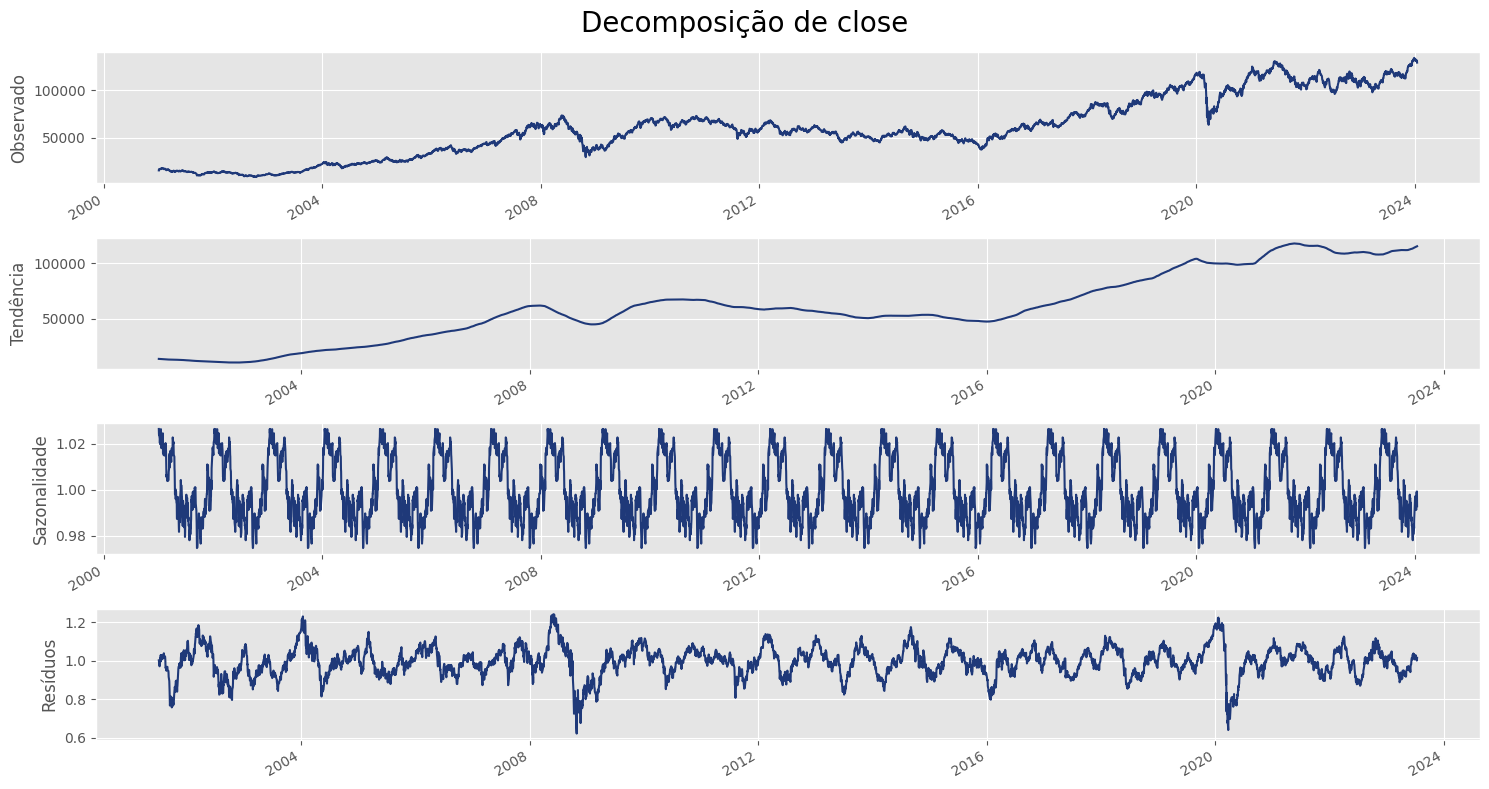

In [103]:
# decompose time series - multiplicative model, 252 days in a year
plot_decomposition(multi_df, column='close')

## Multivariate Analysis

In [104]:
multi_df.head()

# melhorar análise
# refazer análise com outros fatores

close     open  selic   dolar  pib_per_capta        sp500  \
2001-01-02  15425.0  15242.0  15.75  1.9384        7467.03  1333.339966   
2001-01-03  16599.0  15425.0  15.75  1.9422        7467.03  1333.339966   
2001-01-04  16675.0  16597.0  15.75  1.9357        7467.03  1333.339966   
2001-01-05  16410.0  16679.0  15.75  1.9484        7467.03  1298.349976   
2001-01-08  16562.0  16398.0  15.75  1.9524        7467.03  1300.800049   

                  nikkei      vale  petrobras_pn  petrobras_on   itau_pn  
2001-01-02  13691.490234  3.600000       5.91250       6.20125  2.963864  
2001-01-03  13691.490234  3.833333       6.21250       6.63625  3.079935  
2001-01-04  13691.490234  3.708333       6.23750       6.62625  3.129443  
2001-01-05  13867.610352  3.666666       6.25000       6.53750  3.145835  
2001-01-08  13610.509766  3.625000       6.17375       6.50000  3.079769

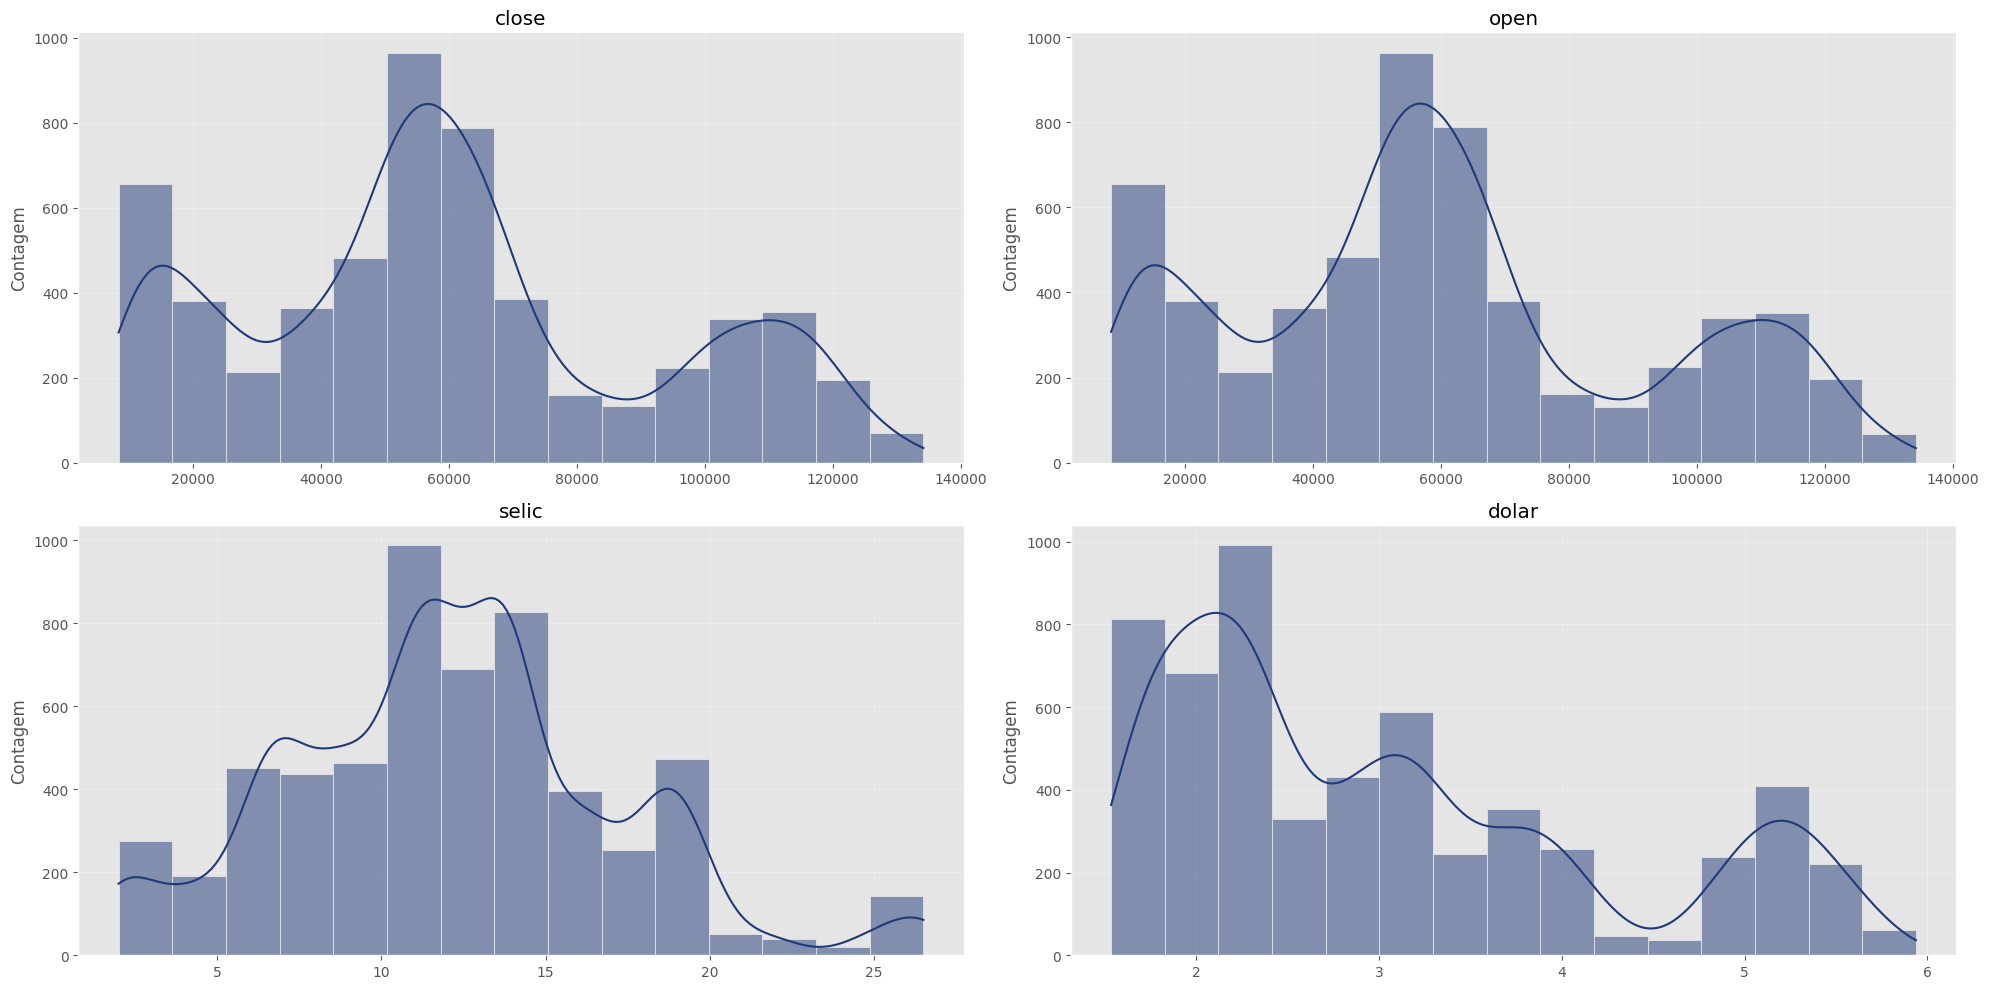

In [105]:
# histplot of each variable that is not close
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
for i in range(2):
    for j in range(2):
        sns.histplot(multi_df[multi_df.columns[2*i + j]], ax=axes[i, j], kde=True, color='#1f3979', bins=15)
        axes[i, j].set_title(multi_df.columns[2*i + j])
        axes[i, j].set_xlabel('')
        axes[i, j].set_ylabel('Contagem')
        axes[i, j].grid(True, alpha=0.3)
        # format x axis
        axes[i, j].xaxis.set_major_formatter('{x:1.0f}')
plt.tight_layout()
plt.show()

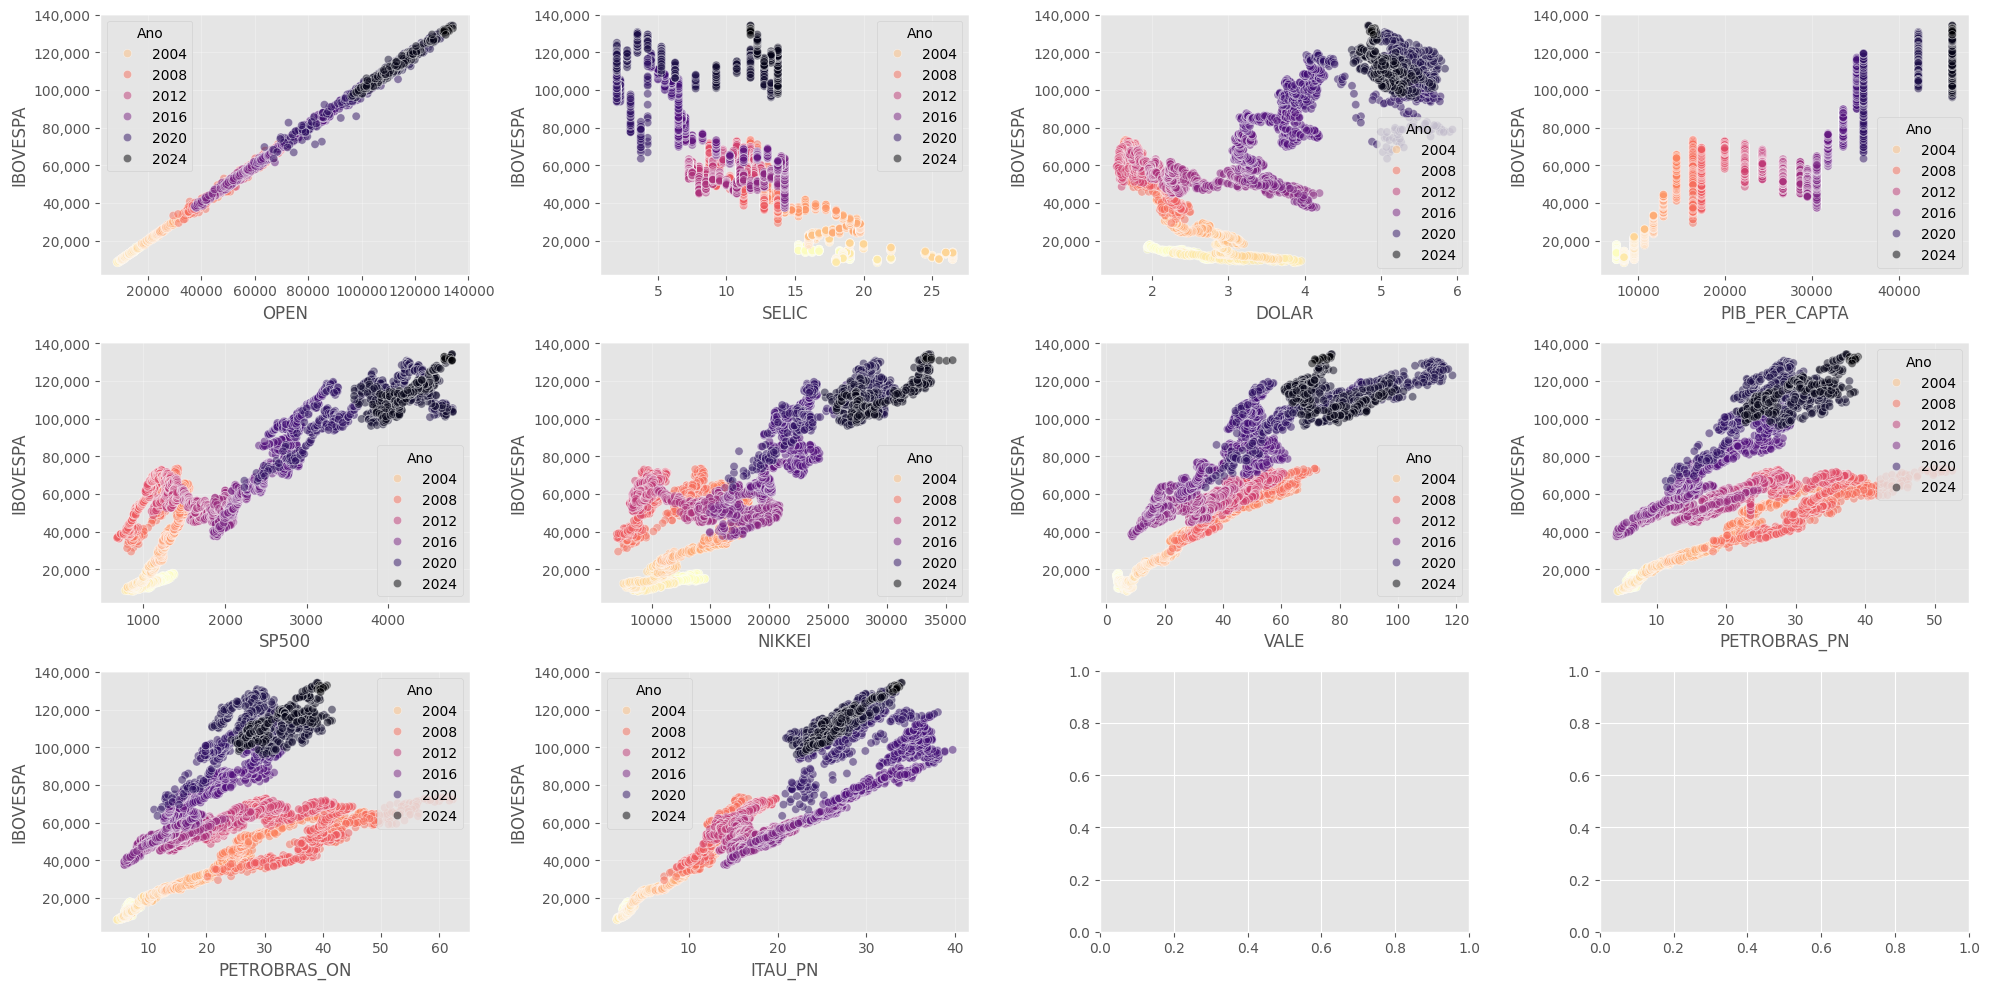

In [106]:
# scatterplot
fig, axes = plt.subplots(3, 4, figsize=(20, 10))
axes = axes.flatten()
cols = ['open', 'selic', 'dolar', 'pib_per_capta', 'sp500', 'nikkei', 'vale',
        'petrobras_pn', 'petrobras_on', 'itau_pn']
for col in cols:
    sns.scatterplot(x=multi_df[col], y=multi_df['close'], ax=axes[cols.index(col)], 
                    alpha=0.5, hue=multi_df.index.year, palette='magma_r')
    axes[cols.index(col)].set_xlabel(col.upper())
    axes[cols.index(col)].set_ylabel('IBOVESPA')
    axes[cols.index(col)].grid(True, alpha=0.3)
    axes[cols.index(col)].legend(title='Ano')
    axes[cols.index(col)].yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.tight_layout()
plt.show()

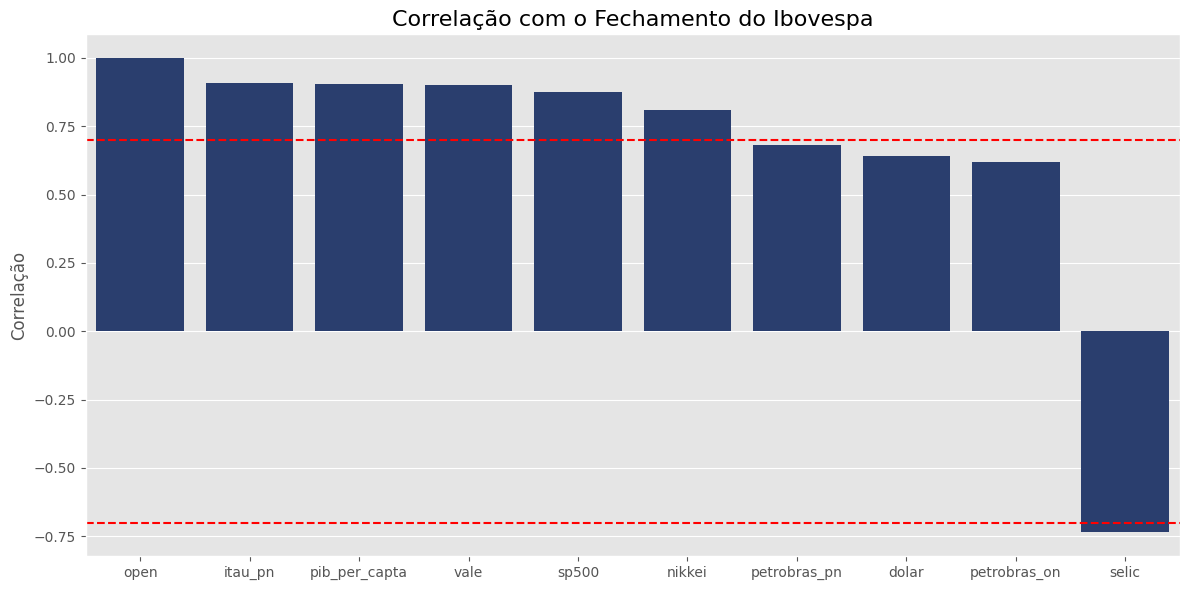

In [107]:
# plot correlations between variables for each day
correl_cols = ['close', 'open', 'selic', 'dolar', 'pib_per_capta', 'sp500', 'nikkei',
                'vale', 'petrobras_pn', 'petrobras_on', 'itau_pn']

corr = multi_df[correl_cols].corr()
# take only the close column
corr = corr[['close']].sort_values(by='close', ascending=False)
# drop line with close
corr.drop('close', inplace=True)

# plot barplot with lines for -0.7 and +0.7
plt.figure(figsize=(12, 6))
sns.barplot(x=corr.index, y=corr['close'], color='#1f3979')
# x title = ações
plt.xlabel('', fontsize=12)
# y title = correlação
plt.ylabel('Correlação', fontsize=12)
# plot lines
plt.axhline(y=0.7, color='red', linestyle='--')
plt.axhline(y=-0.7, color='red', linestyle='--')
plt.title('Correlação com o Fechamento do Ibovespa', fontsize=16)
plt.tight_layout()
plt.show()

In [108]:
# manter apenas correlações maiores ou menores que 0.7
colunas_importantes = corr[(corr['close'] >= 0.7) | (corr['close'] <= -0.7)].index

multi_df = multi_df[['close'] + list(colunas_importantes)]

multi_df.columns

Index(['close', 'open', 'itau_pn', 'pib_per_capta', 'vale', 'sp500', 'nikkei',
       'selic'],
      dtype='object')

In [109]:
# save multi_df in output folder
multi_df.to_csv('output/multi_df.csv')

# save into parquet
multi_df.to_parquet('output/multi_df.parquet') # melhor para carregar tipos